# Pergamino {.unnumbered}

In [1]:
import planetary_computer
import pystac_client
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster
from odc.stac import configure_rio, stac_load

import geopandas as gpd

from pathlib import Path
from matplotlib import colors

from utils.utils import *

CRS_ARGENTINA = "EPSG:5347"
CRS_WGS84 = "EPSG:4326"

RUTA_BASE = Path("/home/nissim/Documents/dev/datos-escala-humana/")
RUTA_DATOS = RUTA_BASE / "data"

base_url = "https://wms.ign.gob.ar/geoserver/ign/ows"

if (RUTA_DATOS / "municipios.geojson").exists():
    munis = gpd.read_file(RUTA_DATOS / "municipios.geojson")
else:
    munis = wfs_to_gdf(wfs_url=base_url, layer_name="ign:municipio", srs="EPSG:4326")

pergamino = munis[munis["nam"] == "Pergamino"]
pergamino = pergamino.to_crs(USE_CRS)

bbox_pergamino_4326 = pergamino.to_crs(CRS_WGS84).total_bounds

In [5]:
# Connect to Planetary Computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [2]:
cluster = LocalCluster(
    processes=True,  # Critical: use processes, not threads
    n_workers=8,  # Use half your cores for workers
    threads_per_worker=2,  # 2 threads per worker = 16 total
    memory_limit="6GB",  # 8 workers × 6GB = 48GB, leaves headroom
)
client = Client(cluster)
print(f"Dask dashboard: {client.dashboard_link}")
configure_rio(cloud_defaults=True, client=client)

/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42147 instead
  warnings.warn(


Dask dashboard: http://127.0.0.1:42147/status


In [6]:
# Query for last 5 years
bbox = bbox_pergamino_4326
datetime = "2020-01-01/2025-01-01"  # Last 5 years
cloudy_less_than = 20  # You might need to be less strict for 5 years of data

query = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloudy_less_than}},
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 488 datasets


In [7]:
# Load only thermal band and QA band
crs = "epsg:3857"
yy = stac_load(
    items,
    bands=("lwir11", "qa_pixel"),
    crs=crs,
    resolution=30,
    chunks={"time": 10},  # Process in chunks of 10 time steps
    groupby="landsat:scene_id",
    bbox=bbox_pergamino_4326,
)


# Create cloud mask function
def create_cloud_mask(qa_band):
    """Mask clouds and cloud shadows"""
    # Bit 3: Cloud, Bit 4: Cloud Shadow
    cloud_mask = (qa_band & 0b11000) == 0
    return cloud_mask


# Apply cloud mask
yy_masked = yy.where(create_cloud_mask(yy.qa_pixel))

# Convert thermal band to LST in Celsius
LST_kelvin = yy_masked["lwir11"] * 0.00341802 + 149.0
LST_celsius = LST_kelvin - 273.15

# Calculate maximum LST per pixel over all time steps
LST_max = LST_celsius.max(dim="time")

from dask.diagnostics import ProgressBar

# Before compute()
print("Computing maximum LST...")
print(f"Dashboard: {client.dashboard_link}")
with ProgressBar():
    LST_max_computed = LST_max.compute()

Computing maximum LST...
Dashboard: http://127.0.0.1:42147/status


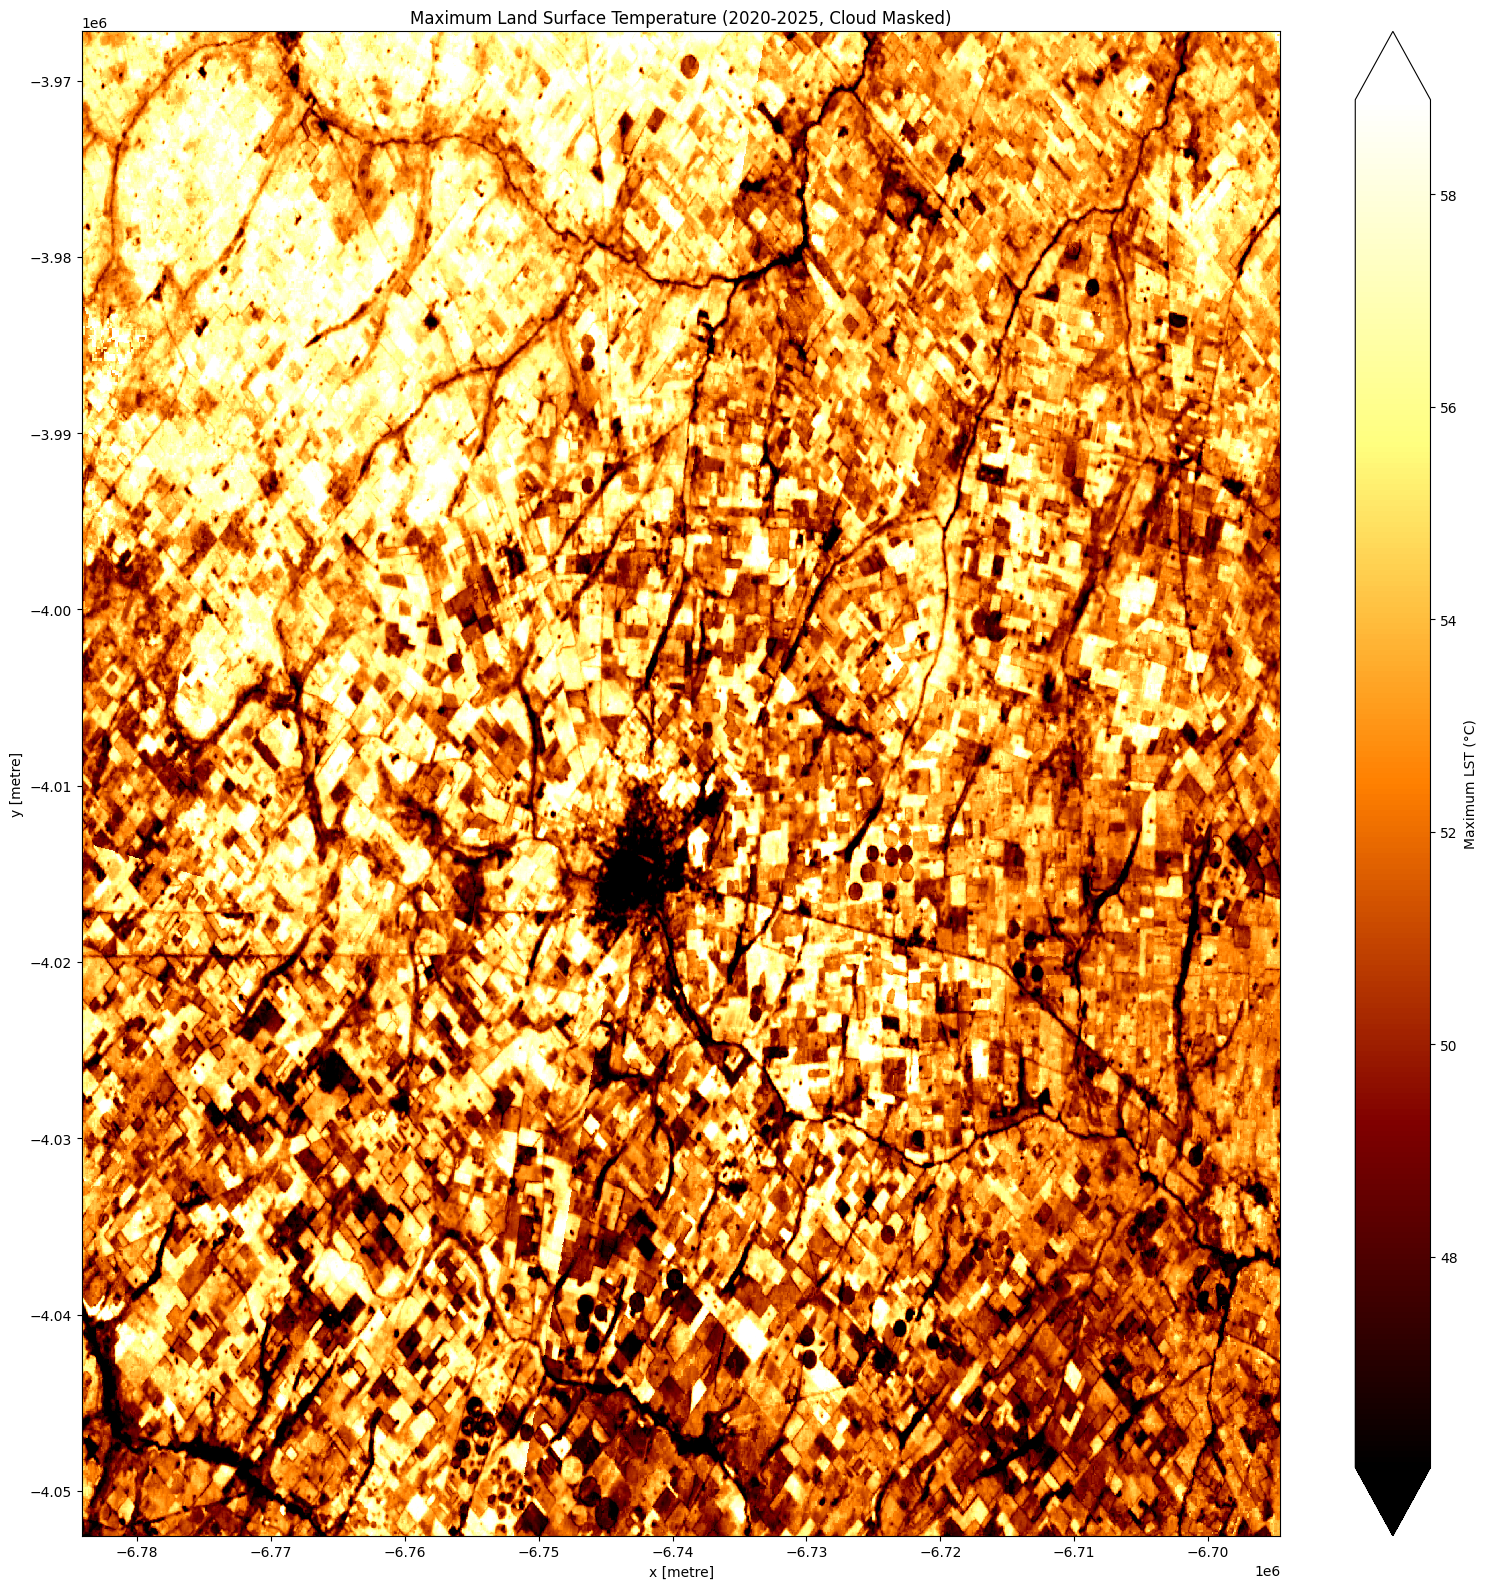

In [8]:
# Plot the result
fig, ax = plt.subplots(figsize=(16, 16))
LST_max_computed.plot.imshow(
    ax=ax,
    cmap="afmhot",
    cbar_kwargs={"label": "Maximum LST (°C)"},
    robust=True,  # Use 2nd and 98th percentiles for color scaling
)
ax.set_title("Maximum Land Surface Temperature (2020-2025, Cloud Masked)")
plt.tight_layout()
plt.show()

In [9]:
# Optional: Save to file
# LST_max_computed.rio.to_raster(RUTA_DATOS / "LST_max_5years.tif")

# Print some statistics
print("\nMaximum LST Statistics:")
print(f"  Overall max: {float(LST_max_computed.max().values):.2f}°C")
print(f"  Overall min: {float(LST_max_computed.min().values):.2f}°C")
print(f"  Mean of maximums: {float(LST_max_computed.mean().values):.2f}°C")
print(f"  Median of maximums: {float(LST_max_computed.median().values):.2f}°C")


Maximum LST Statistics:
  Overall max: 65.36°C
  Overall min: 33.75°C
  Mean of maximums: 52.91°C
  Median of maximums: 52.91°C


## Cobertura del suelo

In [10]:
import rioxarray as rio

# Load the cloud GeoTIFF clipped to your GeoDataFrame
suelo_2022_ruta = "https://storage.googleapis.com/mapbiomas-public/initiatives/argentina/collection-1/coverage/argentina_coverage_2022.tif"

# 1. Use your existing Dask cluster for parallel reads
suelo_2022 = rio.open_rasterio(
    suelo_2022_ruta,
    chunks={"x": 2048, "y": 2048},  # Larger chunks = fewer tasks, faster
    lock=False,  # Critical: allows parallel HTTP reads from GCS
)

from dask.diagnostics import ProgressBar

# For the clip/compute operation
with ProgressBar():
    # 2. Clip efficiently
    suelo_2022 = suelo_2022.rio.clip(
        pergamino.geometry.values,
        pergamino.crs,
        from_disk=True,
        all_touched=False,  # Only pixels with centers inside
    )

In [11]:
# Define the detailed categories and colors
categories_detailed = {
    "Leñosa cerrada": {"ids": [3], "color": "#1f8d49"},
    "Leñosa abierta": {"ids": [4], "color": "#7dc975"},
    "Leñosa dispersa": {"ids": [45], "color": "#807a40"},
    "Leñosa inundable": {"ids": [6], "color": "#026975"},
    "Vegetación no leñosa inundable": {"ids": [11], "color": "#519799"},
    "Pastizal": {"ids": [12], "color": "#d6bc74"},
    "Estepa": {"ids": [63], "color": "#ebf8b5"},
    "Pastura": {"ids": [15], "color": "#edde8e"},
    "Agricultura": {"ids": [18], "color": "#e974ed"},
    "Plantación forestal": {"ids": [9], "color": "#7a5900"},
    "Cultivo arbustivo": {"ids": [36], "color": "#d082de"},
    "Mosaico agropecuario": {"ids": [21], "color": "#ffefc3"},
    "Área sin vegetación": {"ids": [22], "color": "#d4271e"},
    "Río, lago u océano": {"ids": [33], "color": "#2532e4"},
    "Hielo y nieve en superficie": {"ids": [34], "color": "#93dfe6"},
    "No observado": {"ids": [27], "color": "#ffffff"},
}

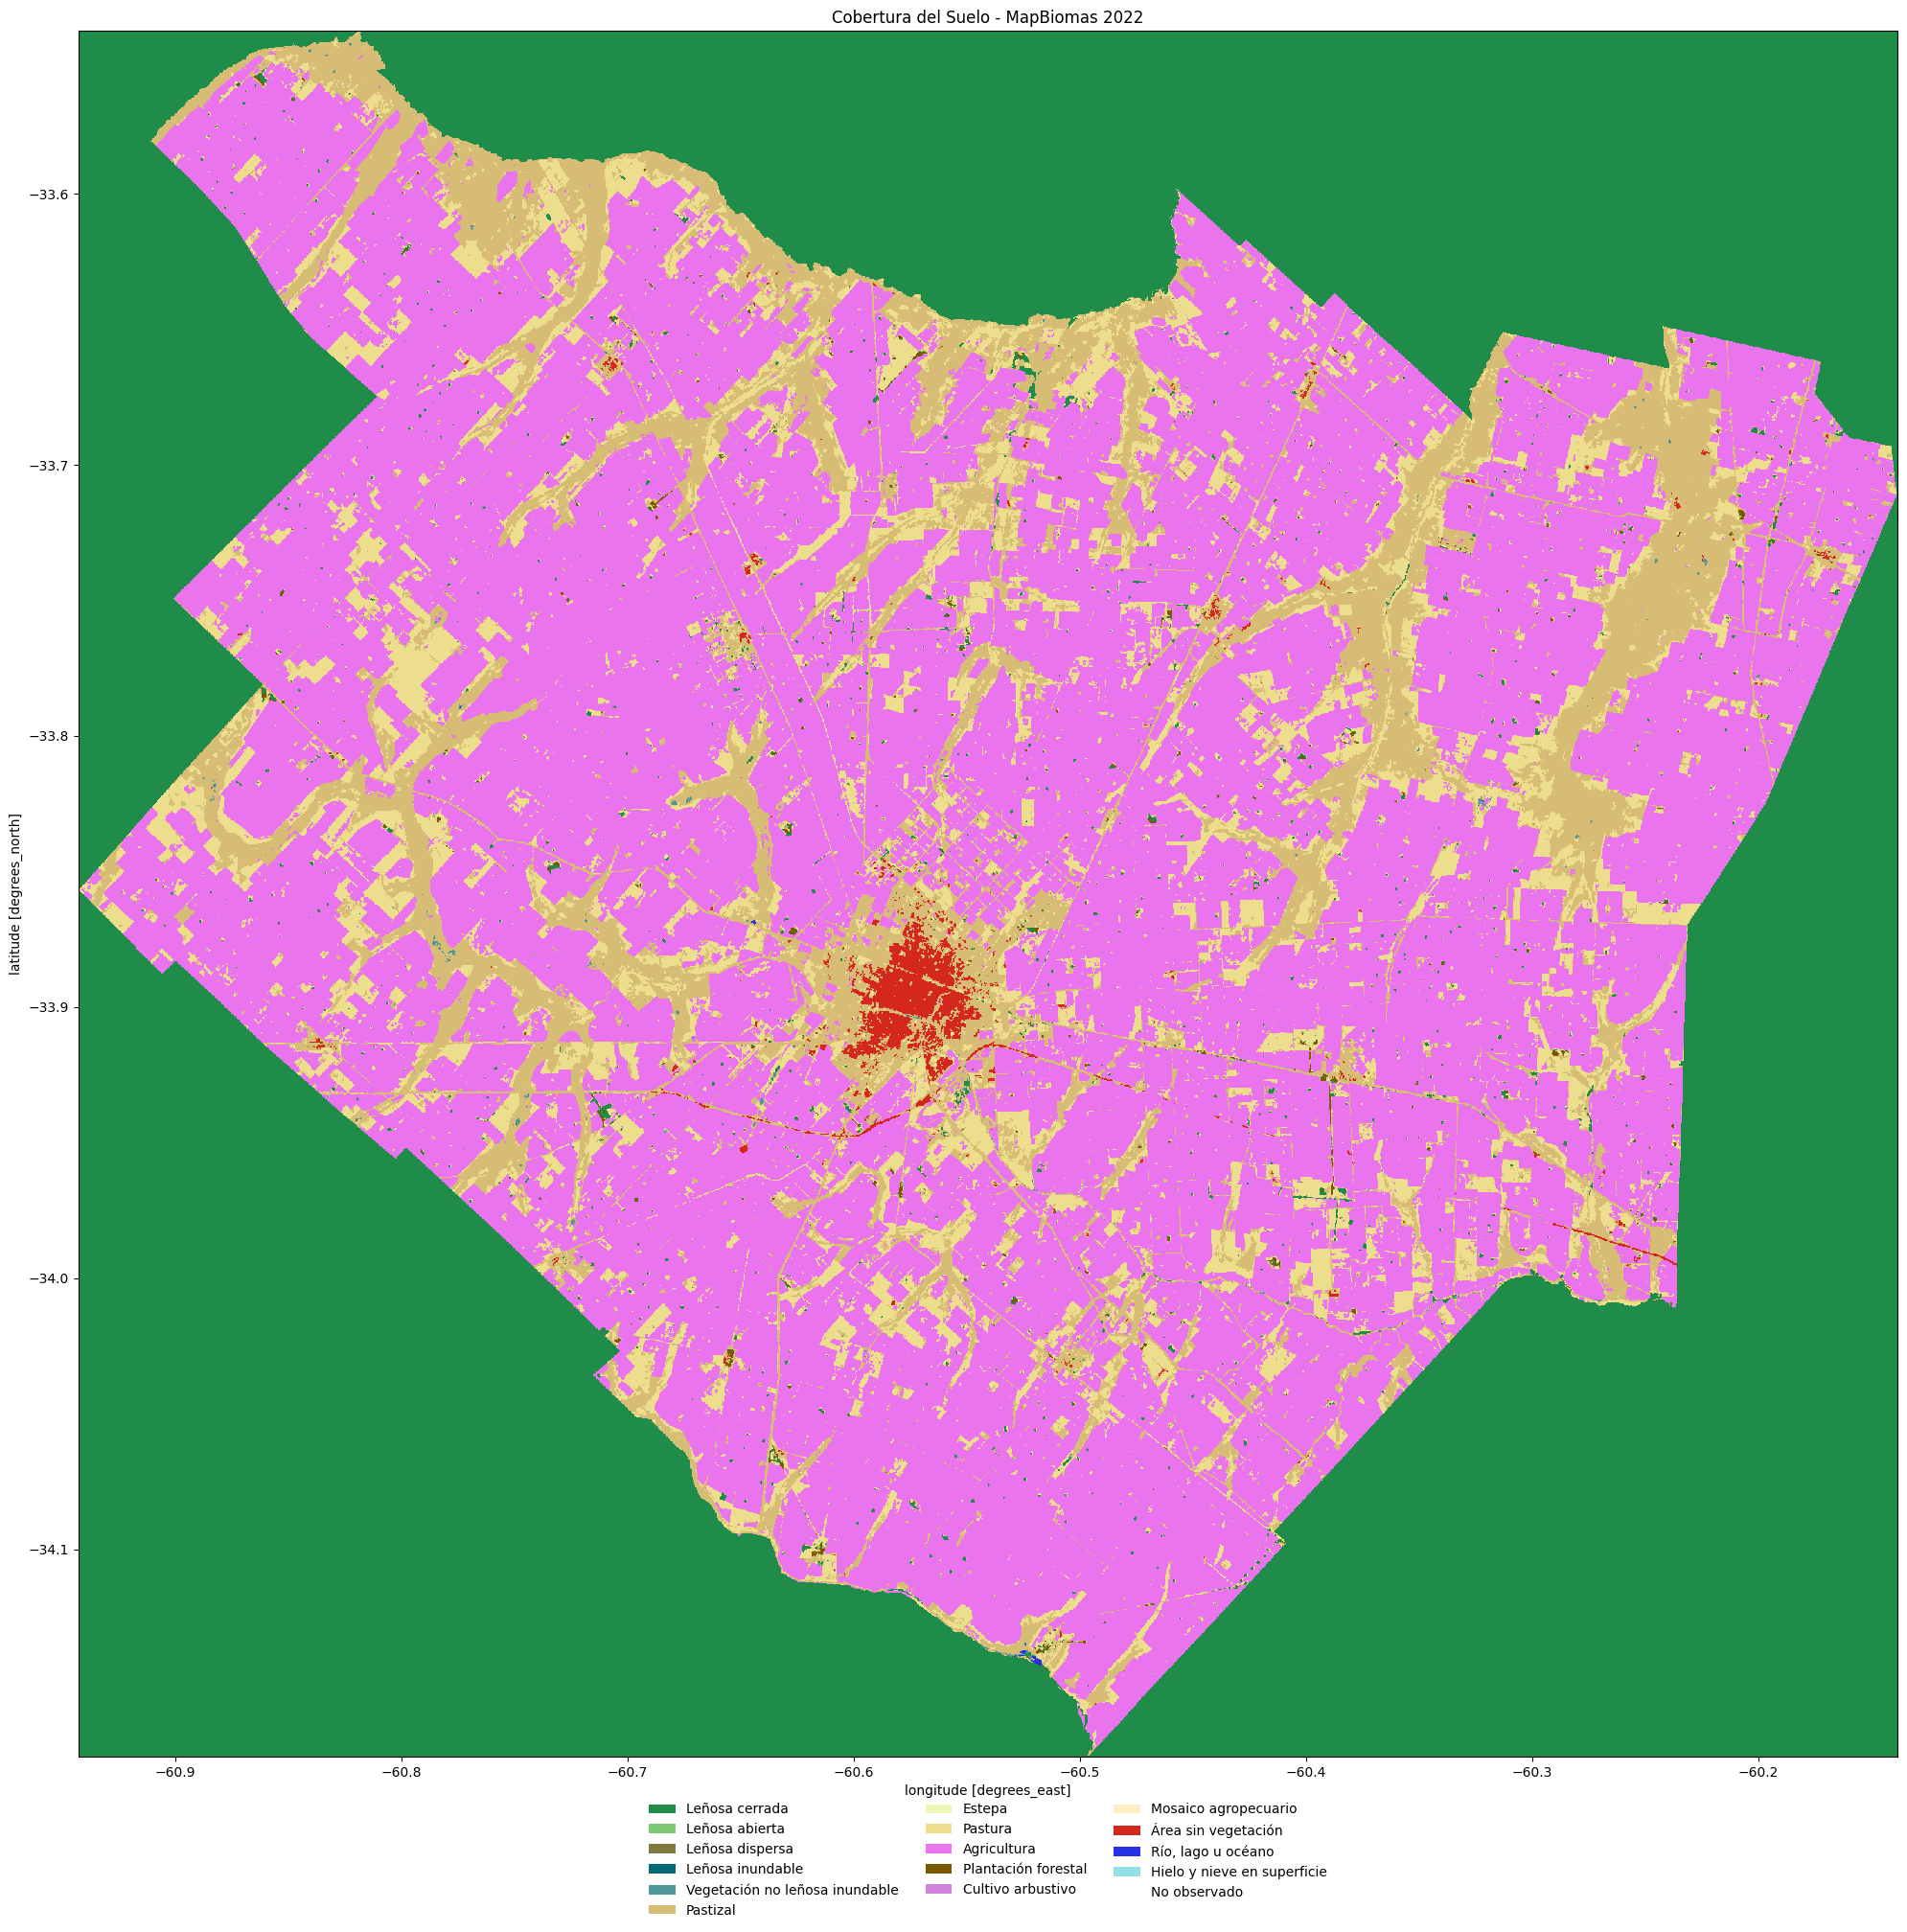

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create colormap from detailed categories
colors = {}
for category, info in categories_detailed.items():
    for pixel_id in info["ids"]:
        colors[pixel_id] = info["color"]

cmap = mcolors.ListedColormap([colors[i] for i in sorted(colors.keys())])
bounds = sorted(colors.keys())
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the raster
im = suelo_2022.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

# Create custom legend from detailed categories
legend_labels = {}
for category, info in categories_detailed.items():
    legend_labels[info["color"]] = category

# Add legend below the map
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor=color, label=label)
    for color, label in legend_labels.items()
]
ax.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    frameon=False,
)

plt.title("Cobertura del Suelo - MapBiomas 2022")
plt.tight_layout()
plt.show()

## Análisis

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Reproject land cover to match LST grid (if needed)
suelo_aligned = suelo_2022.rio.reproject_match(LST_max_computed)

# 2. Flatten both arrays and create DataFrame
lst_flat = LST_max_computed.values.flatten()
landcover_flat = suelo_aligned.values.flatten()

df = pd.DataFrame({"LST": lst_flat, "LandCover": landcover_flat})

# 3. Filter out invalid values
df_clean = df[
    (df["LandCover"] > 0)  # Remove 0
    & (df["LandCover"] < 255)  # Remove 255
    & (~df["LandCover"].isna())  # Remove NaN
    & (~df["LST"].isna())  # Remove LST NaN
].copy()

print(f"Valid pixels: {len(df_clean):,} / {len(df):,}")
print(f"Land cover classes found: {sorted(df_clean['LandCover'].unique())}")

Valid pixels: 4,851,900 / 8,492,325
Land cover classes found: [np.uint8(3), np.uint8(4), np.uint8(9), np.uint8(11), np.uint8(12), np.uint8(15), np.uint8(18), np.uint8(22), np.uint8(33)]


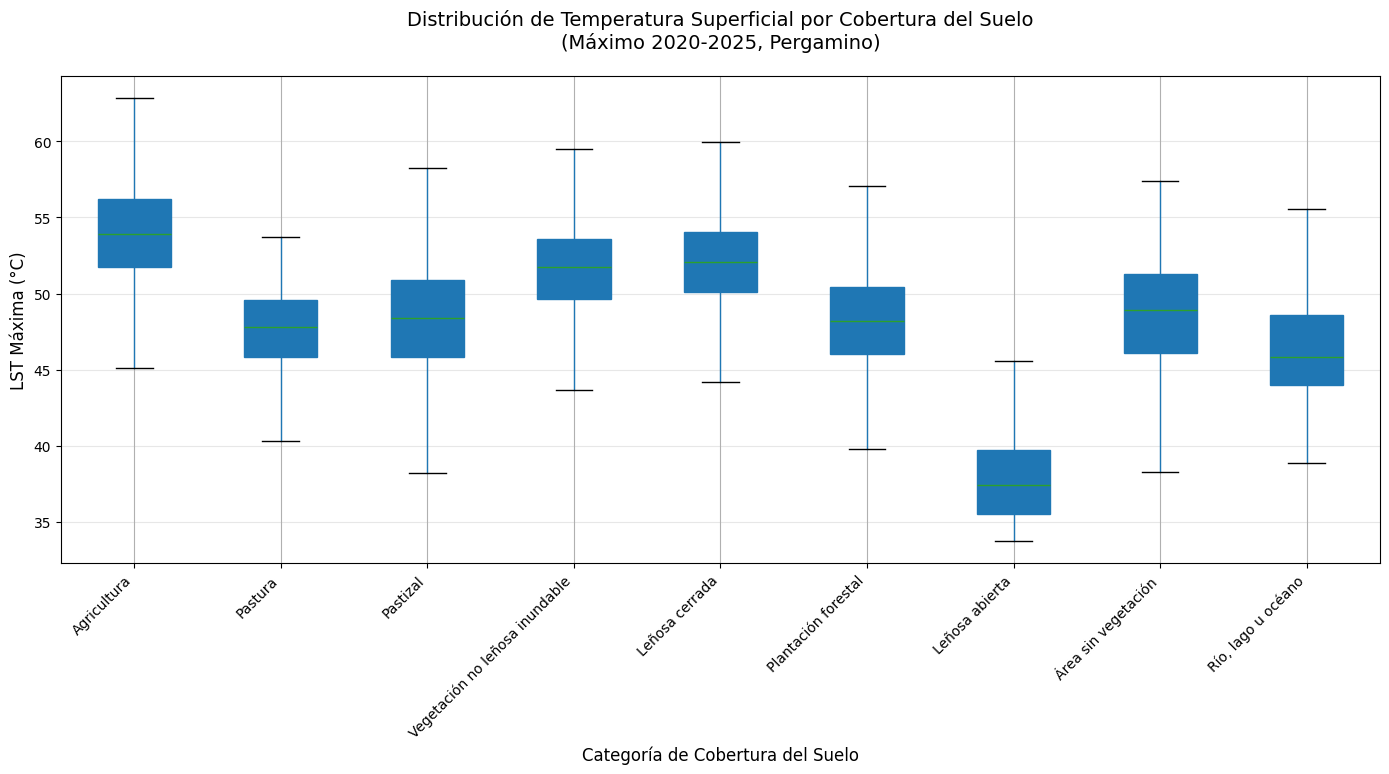

In [59]:
# Create mapping from IDs to category names
id_to_name = {}
for category, details in categories_detailed.items():
    for id_val in details["ids"]:
        id_to_name[id_val] = category

# Add readable names to dataframe
df_clean["Category"] = df_clean["LandCover"].astype(int).map(id_to_name)

# Sort by median LST for better visualization
category_order = (
    df_clean.groupby("Category")["LST"].median().sort_values(ascending=False).index
)

# Box plot with sorted categories
fig, ax = plt.subplots(figsize=(14, 8))
df_clean.boxplot(
    column="LST",
    by="Category",
    ax=ax,
    showfliers=False,  # Hide outliers for cleaner view
    positions=range(len(category_order)),
    patch_artist=True,  # Allows coloring boxes
)

# Set x-axis with sorted order
ax.set_xticklabels(category_order, rotation=45, ha="right")
ax.set_xlabel("Categoría de Cobertura del Suelo", fontsize=12)
ax.set_ylabel("LST Máxima (°C)", fontsize=12)
ax.set_title(
    "Distribución de Temperatura Superficial por Cobertura del Suelo\n(Máximo 2020-2025, Pergamino)",
    fontsize=14,
    pad=20,
)
ax.grid(axis="y", alpha=0.3)
plt.suptitle("")  # Remove default pandas title
plt.tight_layout()
plt.show()

In [60]:
# Summary statistics with Spanish names
summary = (
    df_clean.groupby("Category")["LST"]
    .agg(
        [
            ("Píxeles", "count"),
            ("Media", "mean"),
            ("Mediana", "median"),
            ("Desv. Est.", "std"),
            ("Mín", "min"),
            ("Máx", "max"),
        ]
    )
    .round(2)
    .sort_values("Mediana", ascending=False)
)

print("\nEstadísticas de LST por Categoría:")
summary


Estadísticas de LST por Categoría:


Píxeles      Media    Mediana  Desv. Est.  \
Category                                                                    
Agricultura                     3423500  53.889999  53.889999        2.98   
Pastura                          615394  52.029999  52.060001        2.98   
Pastizal                         747341  51.500000  51.730000        2.85   
Vegetación no leñosa inundable     2645  48.209999  48.919998        4.38   
Leñosa cerrada                    21667  48.310001  48.400002        3.64   
Plantación forestal                7720  48.270000  48.230000        3.15   
Leñosa abierta                      585  47.840000  47.799999        2.47   
Área sin vegetación               32779  46.619999  45.820000        3.53   
Río, lago u océano                  269  38.340000  37.419998        4.02   

                                      Mín        Máx  
Category                                              
Agricultura                     41.610001  65.360001  
Pastura                         37.610001  62.660000  
Pastizal                        35.709999  63.150002  
Vegetación no leñosa inundable  35.840000  57.360001  
Leñosa cerrada                  36.230000  59.180000  
Plantación forestal             37.790001  59.779999  
Leñosa abierta                  40.310001  56.660000  
Área sin vegetación             38.880001  60.590000  
Río, lago u océano              33.750000  52.279999

In [62]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Sample data first (much faster for all tests)
sample_size = 50000
df_sample = df_clean.sample(n=min(sample_size, len(df_clean)), random_state=42)

# 1. One-way ANOVA: Test if ANY categories differ
categories = df_sample["Category"].unique()
groups = [df_sample[df_sample["Category"] == cat]["LST"].values for cat in categories]

f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.2f}")
print(f"p-value: {p_value:.2e}")
print(f"Significant? {'YES' if p_value < 0.05 else 'NO'}\n")

# 2. Effect size (eta-squared) on sample
ss_between = sum([len(g) * (g.mean() - df_sample["LST"].mean()) ** 2 for g in groups])
ss_total = sum([(x - df_sample["LST"].mean()) ** 2 for x in df_sample["LST"]])
eta_squared = ss_between / ss_total
print(f"Eta-squared (effect size): {eta_squared:.3f}")
print("  (0.01=small, 0.06=medium, 0.14=large)\n")

# 3. Tukey HSD: Which pairs differ?
print("Running Tukey HSD (this may take a moment)...")
tukey = pairwise_tukeyhsd(
    endog=df_sample["LST"], groups=df_sample["Category"], alpha=0.05
)
print(tukey)

ANOVA F-statistic: 998.02
p-value: 0.00e+00
Significant? YES

Eta-squared (effect size): 0.138
  (0.01=small, 0.06=medium, 0.14=large)

Running Tukey HSD (this may take a moment)...
                         Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
            group1                         group2             meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------------------------------------
                   Agricultura                 Leñosa abierta  -4.9853 0.0003  -8.4816  -1.489   True
                   Agricultura                 Leñosa cerrada  -5.6442    0.0  -6.2509 -5.0376   True
                   Agricultura                       Pastizal  -2.4152    0.0  -2.5311 -2.2994   True
                   Agricultura                        Pastura  -1.8154    0.0  -1.9416 -1.6891   True
                   Agricultura            Plantación forestal  -5.8523    0.0   -7.028 -4.6765   True
  

In [63]:
# Compare variability
for cat in ["Agricultura", "Área sin vegetación"]:
    data = df_clean[df_clean["Category"] == cat]["LST"]
    print(f"{cat}:")
    print(f"  Mean: {data.mean():.2f}°C")
    print(f"  Std: {data.std():.2f}°C")
    print(f"  Max: {data.max():.2f}°C")
    print(f"  95th percentile: {data.quantile(0.95):.2f}°C\n")

Agricultura:
  Mean: 53.89°C
  Std: 2.98°C
  Max: 65.36°C
  95th percentile: 58.53°C

Área sin vegetación:
  Mean: 46.62°C
  Std: 3.53°C
  Max: 60.59°C
  95th percentile: 53.69°C



Píxeles de 'Área sin vegetación': 32,779
Rango LST: 38.88°C - 60.59°C


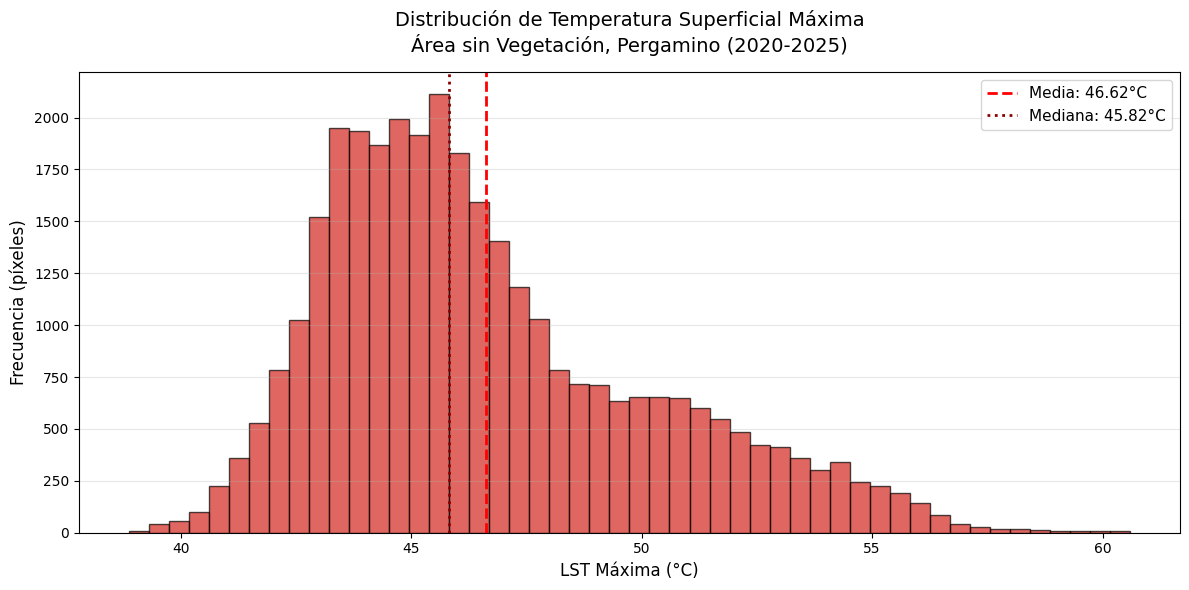

In [18]:
# Filter for just "Área sin vegetación" (ID 22)
df_bare = df_clean[df_clean["Category"] == "Área sin vegetación"]

print(f"Píxeles de 'Área sin vegetación': {len(df_bare):,}")
print(f"Rango LST: {df_bare['LST'].min():.2f}°C - {df_bare['LST'].max():.2f}°C")

# Histogram
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(
    df_bare["LST"],
    bins=50,
    color="#d4271e",  # Use the MapBiomas color for this class
    edgecolor="black",
    alpha=0.7,
)
ax.axvline(
    df_bare["LST"].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Media: {df_bare['LST'].mean():.2f}°C",
)
ax.axvline(
    df_bare["LST"].median(),
    color="darkred",
    linestyle=":",
    linewidth=2,
    label=f"Mediana: {df_bare['LST'].median():.2f}°C",
)

ax.set_xlabel("LST Máxima (°C)", fontsize=12)
ax.set_ylabel("Frecuencia (píxeles)", fontsize=12)
ax.set_title(
    "Distribución de Temperatura Superficial Máxima\nÁrea sin Vegetación, Pergamino (2020-2025)",
    fontsize=14,
    pad=15,
)
ax.legend(fontsize=11)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## Edificios

In [ ]:
import math
import geopandas as gpd
import duckdb
import os

import matplotlib.pyplot as plt

import geopandas as gpd


import pandas as pd


from io import BytesIO


WEB_MERCATOR_CRS = "EPSG:3857"

# Your existing AOI geometry
# pergamino = gpd.read_file("pergamino.geojson")  # Example if not already loaded
CRS_WGS84 = "EPSG:4326"

# Output file
EDIFICACIONES_RUTA = "edificaciones_pergamino_gba.parquet"

# 1️⃣ Compute bounding box in WGS84
aoi_bounds = pergamino.to_crs(CRS_WGS84).total_bounds  # [xmin, ymin, xmax, ymax]
xmin, ymin, xmax, ymax = aoi_bounds
print(f"Caja delimitadora de Pergamino: {aoi_bounds}")


# 2️⃣ Compute overlapping 5°×5° tiles
def tile_name(lon_min, lat_min):
    """Return a tile filename component given SW corner (lon_min, lat_min)."""
    ew = "e" if lon_min >= 0 else "w"
    ns = "n" if lat_min >= 0 else "s"
    lon_tag = f"{abs(int(lon_min)):03d}"
    lat_tag = f"{abs(int(lat_min)):02d}"
    return ew + lon_tag + "_" + ns + lat_tag


# Compute all overlapping 5° grid indices
lon_starts = range(
    int(math.floor(xmin / 5.0)) * 5, int(math.ceil(xmax / 5.0)) * 5 + 5, 5
)
lat_starts = range(
    int(math.floor(ymin / 5.0)) * 5, int(math.ceil(ymax / 5.0)) * 5 + 5, 5
)

tiles = []
for lon0 in lon_starts:
    for lat0 in lat_starts:
        lon1 = lon0 + 5
        lat1 = lat0 + 5
        name = f"{tile_name(lon0, lat1)}_{tile_name(lon1, lat0)}.parquet"
        tiles.append(name)

print("Posibles tiles a usar:")
for t in tiles:
    print("  ", t)

# 3️⃣ Base URL for dataset
BASE_URL = "https://data.source.coop/tge-labs/globalbuildingatlas-lod1/"
urls = [BASE_URL + t for t in tiles]

# 4️⃣ Connect to DuckDB
con = duckdb.connect()
for cmd in [
    "INSTALL spatial",
    "LOAD spatial",
    "INSTALL httpfs",
    "LOAD httpfs",
    "SET s3_url_style='path'",
    "SET s3_use_ssl=true",
]:
    con.execute(cmd)

# 5️⃣ Query & filter each tile by AOI bbox
if os.path.exists(EDIFICACIONES_RUTA):
    print("Cargando edificaciones existentes...")
    edificaciones = gpd.read_parquet(EDIFICACIONES_RUTA)
else:
    print("Descargando y filtrando datos de Global Building Atlas (LOD1)...")

    aoi_filter = f"""
    bbox.xmax >= {xmin} AND bbox.xmin <= {xmax} AND
    bbox.ymax >= {ymin} AND bbox.ymin <= {ymax}
    """

    # Combine all matching tiles
    query = f"""
    COPY (
        SELECT id, height, geometry
        FROM read_parquet({urls}, filename=true)
        WHERE {aoi_filter}
    ) TO '{EDIFICACIONES_RUTA}' (FORMAT PARQUET);
    """

    con.execute(query)
    print("Datos guardados localmente como Parquet.")

    # Load into GeoDataFrame
    df = gpd.read_parquet(EDIFICACIONES_RUTA)
    # The geometry column is already shapely Polygon objects
    edificaciones = gpd.GeoDataFrame(df, geometry="geometry", crs=CRS_WGS84)


# 6️⃣ Clip to AOI
edificaciones = edificaciones.to_crs(CRS_ARGENTINA)
edificaciones = edificaciones[edificaciones.intersects(pergamino.geometry.iloc[0])]
print(f"Total de edificaciones dentro de Pergamino: {len(edificaciones)}")

Caja delimitadora de Pergamino: [-60.942796   -34.17645991 -60.138771   -33.54020044]
Posibles tiles a usar:
   w065_s30_w060_s35.parquet
   w065_s25_w060_s30.parquet
   w060_s30_w055_s35.parquet
   w060_s25_w055_s30.parquet
Cargando edificaciones existentes...
Total de edificaciones dentro de Pergamino: 116088


In [33]:
edificaciones.head()

id    height  \
1778  47QXXQW6+45P6  0.028760   
1779  47QXXPWV+PJW6  1.868949   
1822  47RX2P29+28R3  3.053921   
1853  47QXXMH6+6PV3  4.396781   
1854  47QXXMH6+CRWM  3.774358   

                                               geometry  
1778  POLYGON ((5477871.218 6237760.117, 5477871.13 ...  
1779  POLYGON ((5476358.204 6237921.461, 5476360.606...  
1822  POLYGON ((5473981.123 6238290.4, 5473971.042 6...  
1853  POLYGON ((5468767.71 6235829.022, 5468764.191 ...  
1854  POLYGON ((5468800.321 6235883.504, 5468791.23 ...

In [37]:
edificaciones["height"].isna().sum()

np.int64(0)

array([[<Axes: title={'center': 'height'}>]], dtype=object)

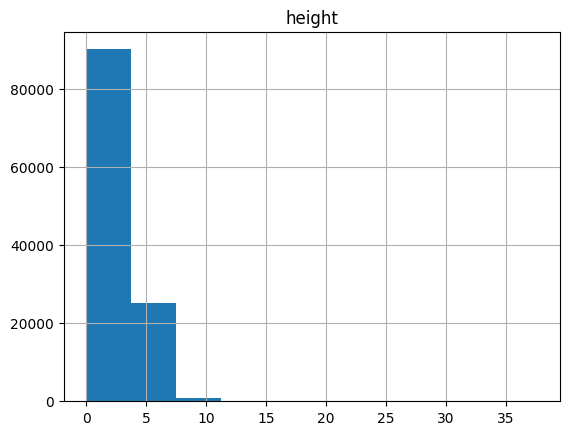

In [35]:
edificaciones.hist("height")

<Axes: >

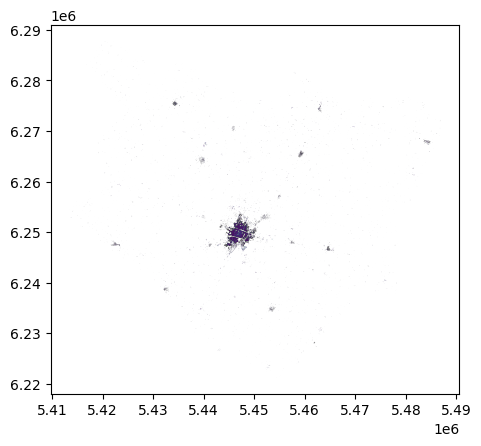

In [34]:
edificaciones.plot("height", cmap="viridis")

In [39]:
from geocube.api.core import make_geocube

# 1. Calculate building volume (footprint area × height)
edificaciones["area"] = edificaciones.geometry.area  # in CRS units (m²)
edificaciones["volume"] = edificaciones["area"] * edificaciones["height"].fillna(0)

In [46]:
# 1. Reproject template to match buildings CRS (meters)
template_projected = template.rio.reproject("EPSG:5347")

# 2. Recalculate areas in proper CRS
edificaciones_aligned = edificaciones.to_crs("EPSG:5347")  # Should already be there
edificaciones_aligned["area"] = edificaciones_aligned.geometry.area
edificaciones_aligned["volume"] = edificaciones_aligned["area"] * edificaciones_aligned[
    "height"
].fillna(0)

# 3. Rasterize using projected template
building_cube = make_geocube(
    vector_data=edificaciones_aligned,
    measurements=["volume"],
    like=template_projected,
    fill=0,
)

# 4. Calculate pixel area in meters (now correct)
pixel_width = abs(float(template_projected.rio.resolution()[0]))
pixel_height = abs(float(template_projected.rio.resolution()[1]))
pixel_area = pixel_width * pixel_height

print(f"Pixel size: {pixel_width:.2f} × {pixel_height:.2f} m")
print(f"Pixel area: {pixel_area:.2f} m²")

# 5. Normalize properly
volume_density = building_cube["volume"] / pixel_area

print(
    f"Volume density range: {float(volume_density.min()):.2f} - {float(volume_density.max()):.2f} m³/m²"
)

Pixel size: 26.95 × 26.95 m
Pixel area: 726.56 m²
Volume density range: 0.00 - 193.97 m³/m²


Total pixels: 7,311,984
Non-zero pixels: 12,594
Range: 0.00 - 193.97 m³/m²


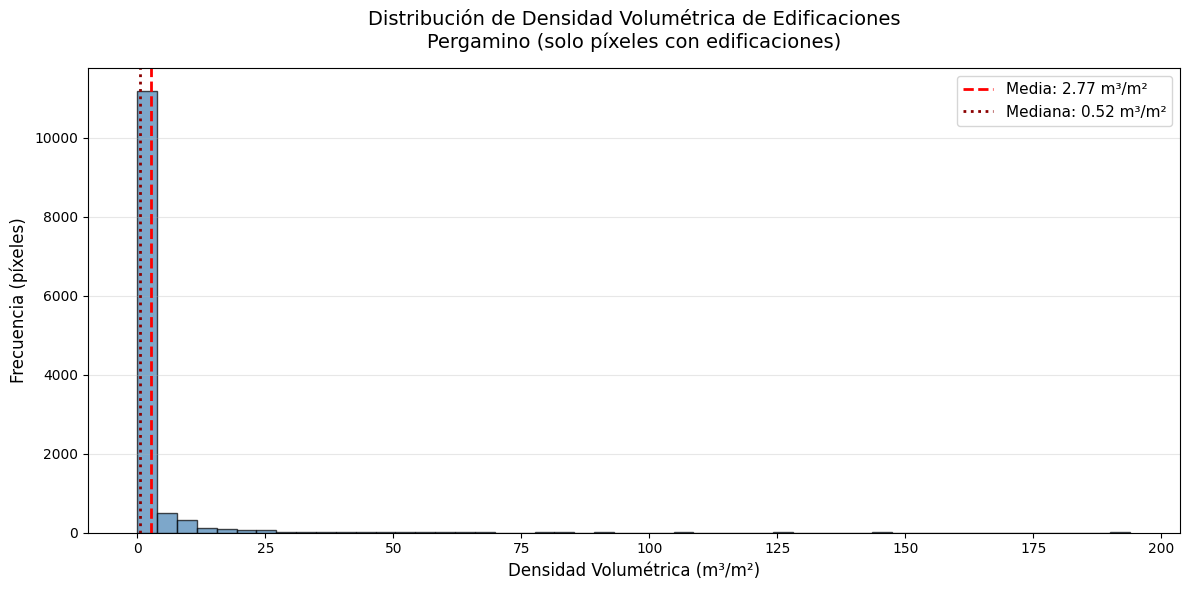


Estadísticas:
  Media: 2.77 m³/m²
  Mediana: 0.52 m³/m²
  Desv. Est.: 10.84 m³/m²
  Percentil 95: 10.77 m³/m²


In [48]:
# Get non-zero values for histogram
values = volume_density.values.flatten()
values_nonzero = values[values > 0]

print(f"Total pixels: {len(values):,}")
print(f"Non-zero pixels: {len(values_nonzero):,}")
print(f"Range: {values_nonzero.min():.2f} - {values_nonzero.max():.2f} m³/m²")

# Histogram
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(values_nonzero, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
ax.axvline(
    values_nonzero.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Media: {values_nonzero.mean():.2f} m³/m²",
)
ax.axvline(
    np.median(values_nonzero),
    color="darkred",
    linestyle=":",
    linewidth=2,
    label=f"Mediana: {np.median(values_nonzero):.2f} m³/m²",
)

ax.set_xlabel("Densidad Volumétrica (m³/m²)", fontsize=12)
ax.set_ylabel("Frecuencia (píxeles)", fontsize=12)
ax.set_title(
    "Distribución de Densidad Volumétrica de Edificaciones\nPergamino (solo píxeles con edificaciones)",
    fontsize=14,
    pad=15,
)
ax.legend(fontsize=11)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Additional stats
print("\nEstadísticas:")
print(f"  Media: {values_nonzero.mean():.2f} m³/m²")
print(f"  Mediana: {np.median(values_nonzero):.2f} m³/m²")
print(f"  Desv. Est.: {values_nonzero.std():.2f} m³/m²")
print(f"  Percentil 95: {np.percentile(values_nonzero, 95):.2f} m³/m²")

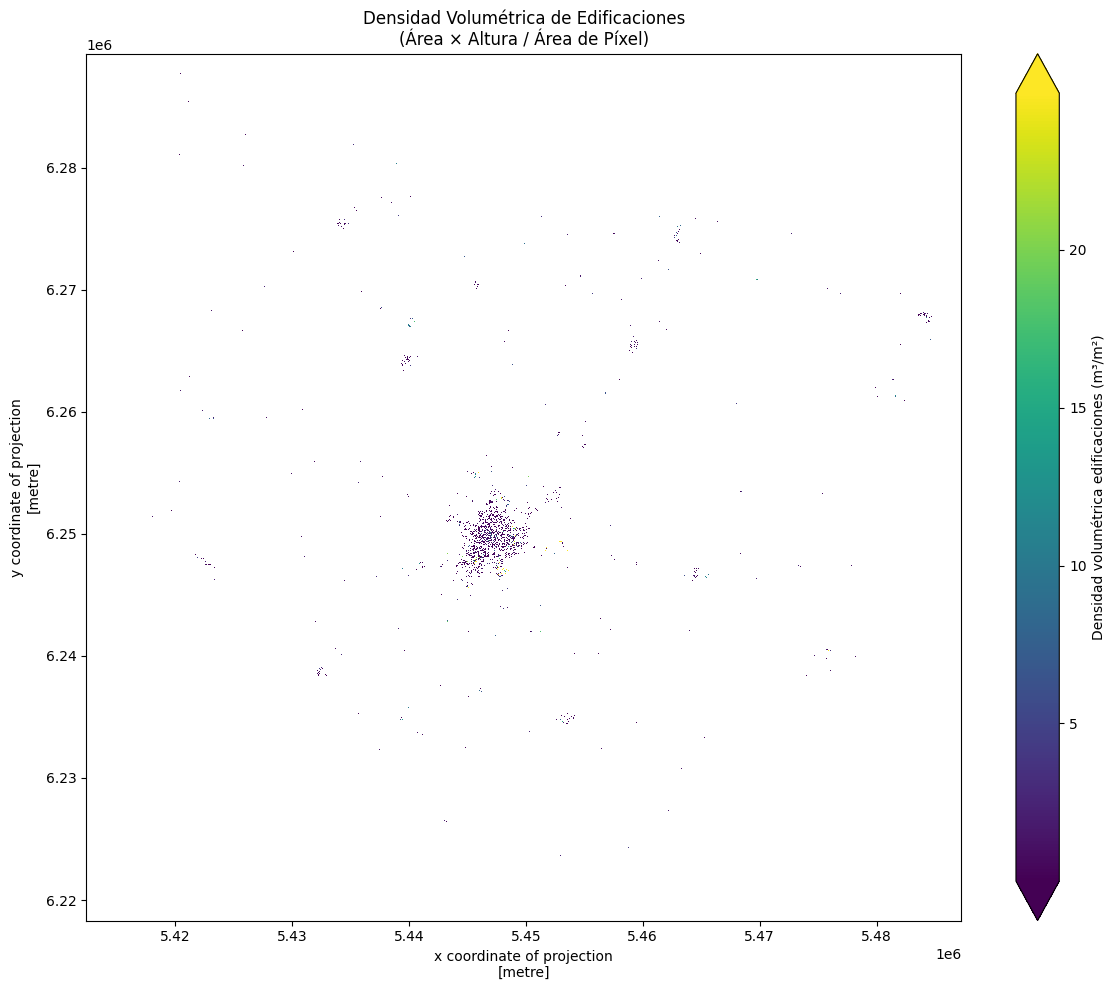

In [47]:
# Mask out 0 values for plotting
volume_density_masked = volume_density.where(volume_density > 0)

# Optional: Visualize
fig, ax = plt.subplots(figsize=(12, 10))
volume_density_masked.plot(
    ax=ax,
    cmap="viridis",
    cbar_kwargs={"label": "Densidad volumétrica edificaciones (m³/m²)"},
    robust=True,
)
ax.set_title("Densidad Volumétrica de Edificaciones\n(Área × Altura / Área de Píxel)")
plt.tight_layout()
plt.show()

Píxeles urbanos válidos: 9,211


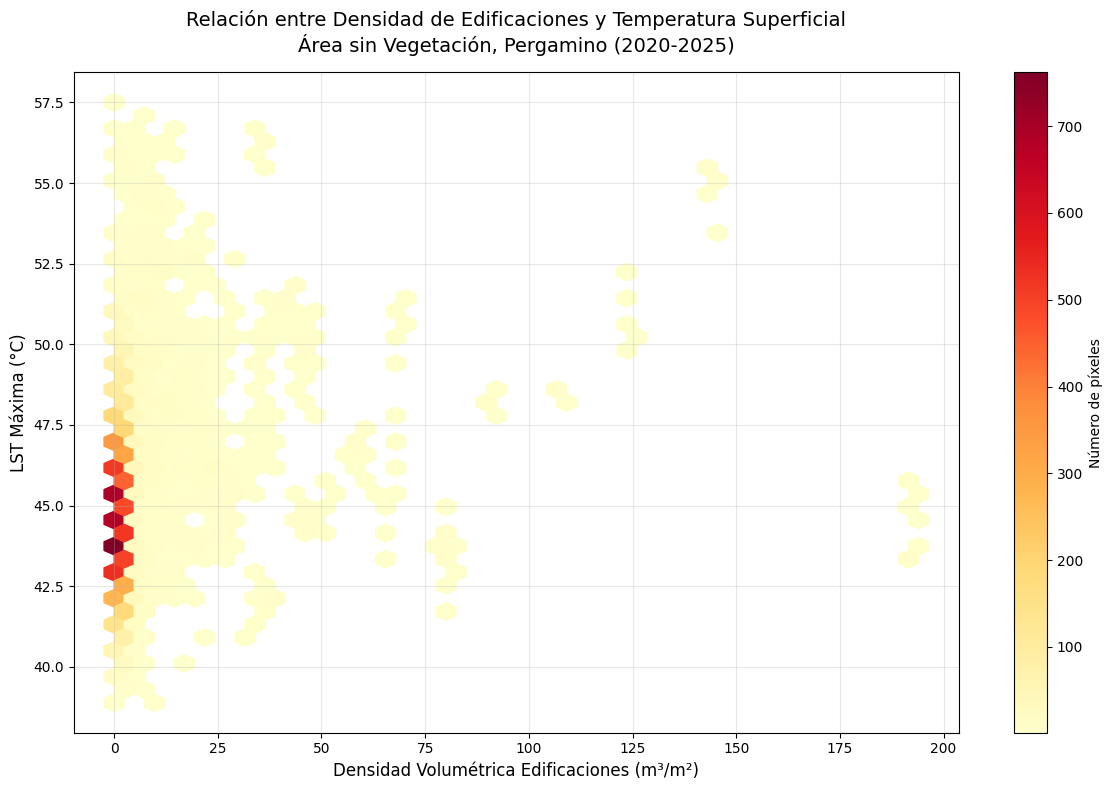


Correlación: 0.210


In [51]:
# 1. Align all rasters to same grid
volume_density_aligned = volume_density.rio.reproject_match(LST_max_computed)
suelo_aligned = suelo_2022.rio.reproject_match(LST_max_computed)

# 2. Flatten arrays
lst_flat = LST_max_computed.values.flatten()
density_flat = volume_density_aligned.values.flatten()
landcover_flat = suelo_aligned.values.flatten()

# 3. Filter for urban pixels (ID 22) with valid data
urban_mask = (
    (landcover_flat == 22)
    & (~np.isnan(lst_flat))
    & (~np.isnan(density_flat))
    & (density_flat > 0)
)

lst_urban = lst_flat[urban_mask]
density_urban = density_flat[urban_mask]

print(f"Píxeles urbanos válidos: {len(lst_urban):,}")

# 4. Scatterplot
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.hexbin(density_urban, lst_urban, gridsize=40, cmap="YlOrRd", mincnt=1)
plt.colorbar(scatter, ax=ax, label="Número de píxeles")

ax.set_xlabel("Densidad Volumétrica Edificaciones (m³/m²)", fontsize=12)
ax.set_ylabel("LST Máxima (°C)", fontsize=12)
ax.set_title(
    "Relación entre Densidad de Edificaciones y Temperatura Superficial\nÁrea sin Vegetación, Pergamino (2020-2025)",
    fontsize=14,
    pad=15,
)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation
correlation = np.corrcoef(density_urban, lst_urban)[0, 1]
print(f"\nCorrelación: {correlation:.3f}")

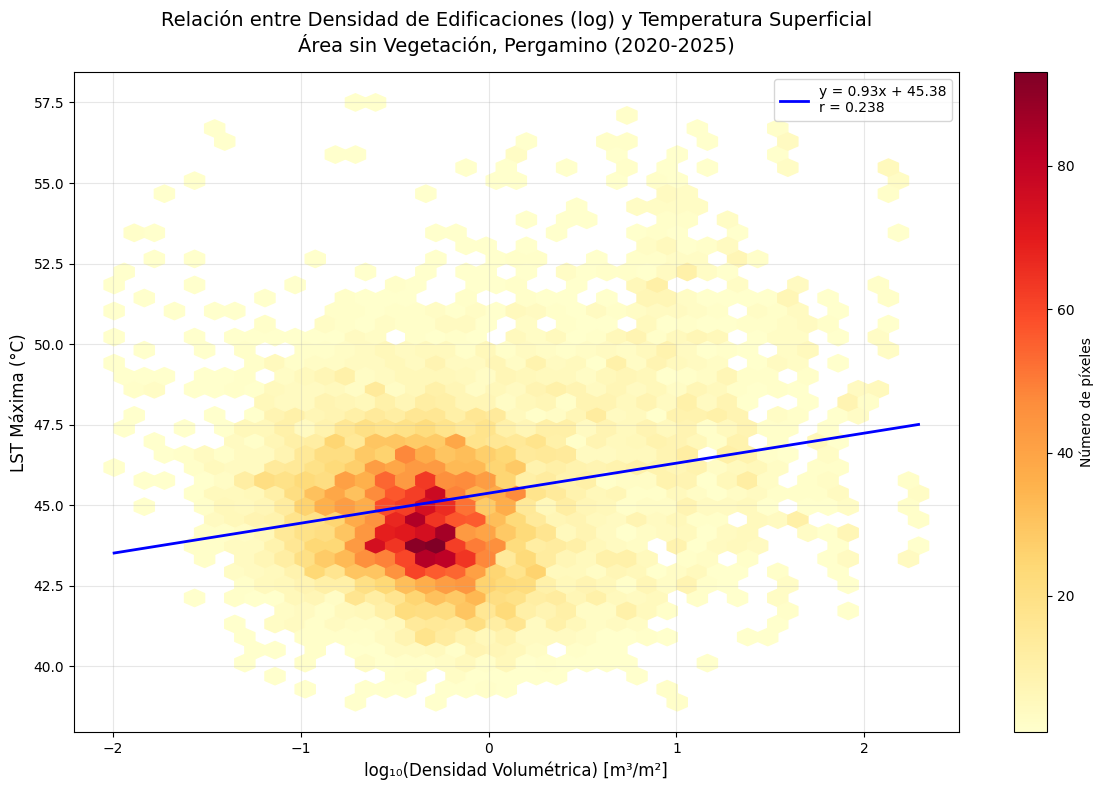


Correlación (densidad log-transformada): 0.238
Correlación (densidad original): 0.210

Densidad original:
  Percentiles: 25%=0.27, 50%=0.53, 75%=1.30, 95%=15.13


In [ ]:
# Log transform density (add small constant to avoid log(0))
density_urban_log = np.log10(density_urban + 0.01)

# Scatterplot with log-transformed density
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.hexbin(density_urban_log, lst_urban, gridsize=40, cmap="YlOrRd", mincnt=1)
plt.colorbar(scatter, ax=ax, label="Número de píxeles")

# Add linear regression line
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(
    density_urban_log, lst_urban
)

# On your existing plot:
x_line = np.linspace(density_urban_log.min(), density_urban_log.max(), 100)
y_line = slope * x_line + intercept
ax.plot(
    x_line,
    y_line,
    "b-",
    linewidth=2,
    label=f"y = {slope:.2f}x + {intercept:.2f}\nr = {r_value:.3f}",
)
ax.legend()

ax.set_xlabel("log₁₀(Densidad Volumétrica) [m³/m²]", fontsize=12)
ax.set_ylabel("LST Máxima (°C)", fontsize=12)
ax.set_title(
    "Relación entre Densidad de Edificaciones (log) y Temperatura Superficial\nÁrea sin Vegetación, Pergamino (2020-2025)",
    fontsize=14,
    pad=15,
)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation with log-transformed data
correlation_log = np.corrcoef(density_urban_log, lst_urban)[0, 1]
print(f"\nCorrelación (densidad log-transformada): {correlation_log:.3f}")
print(
    f"Correlación (densidad original): {np.corrcoef(density_urban, lst_urban)[0, 1]:.3f}"
)

# Distribution check
print("\nDensidad original:")
print(
    f"  Percentiles: 25%={np.percentile(density_urban, 25):.2f}, 50%={np.percentile(density_urban, 50):.2f}, 75%={np.percentile(density_urban, 75):.2f}, 95%={np.percentile(density_urban, 95):.2f}"
)

## Cursos de agua

In [ ]:
import requests
import geopandas as gpd

# Base WMS URL (clean up the malformed URL)
wms_url = "https://ide.pergamino.gob.ar:8443/geoserver/wms"
layer_name = "publico:cursos_de_agua"

Available layers:
  - publico:base
  - publico:aeropuertos
  - publico:agencias_de_viaje
  - publico:agencias_gubernamentales
  - publico:aglomerados_urbanos
  - publico:alcantarillas_vialidad
  - publico:altura_de_calle
  - publico:arbolado
  - publico:areas_fiscalizadas_construcciones
  - publico:areas_programaticas_desarrollo_social
  - publico:areas_programaticas_salud
  - publico:banados
  - publico:barrido_y_limpieza
  - publico:barrios
  - publico:beata_crescencia_perez
  - publico:bibliotecas
  - publico:bocas_pago_tasas
  - publico:bomberos
  - publico:calidad_vivienda
  - publico:callejero
  - publico:camaras_seguridad
  - publico:camaras_y_radares
  - publico:caps
  - publico:carteles_viales
  - publico:catastro_chacra
  - publico:catastro_circunscripcion
  - publico:catastro_fraccion
  - publico:catastro_manzana
  - publico:catastro_medida_lado
  - publico:catastro_parcela
  - publico:catastro_ph
  - publico:catastro_quinta
  - publico:catastro_seccion
  - publico:catastro_

In [74]:
wfs_url = "https://ide.pergamino.gob.ar:8443/geoserver/wfs"
layer_name = "publico:cursos_de_agua"

# Build GetFeature request
bbox = pergamino.to_crs("EPSG:4326").total_bounds

params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typename": layer_name,
    "outputFormat": "application/json",
    "srsname": "EPSG:4326",
    "bbox": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]},EPSG:4326",
}

response = requests.get(wfs_url, params=params)

if response.status_code == 200:
    cursos_agua_gdf = gpd.read_file(BytesIO(response.content))
    print(f"Loaded {len(cursos_agua_gdf)} watercourse features")
    print(f"CRS: {cursos_agua_gdf.crs}")

    # Clip to exact Pergamino boundary
    cursos_agua_gdf = cursos_agua_gdf.to_crs(pergamino.crs)

else:
    print(f"Error: {response.status_code}")
    print(response.text)

Loaded 430 watercourse features
CRS: EPSG:4326


<Axes: >

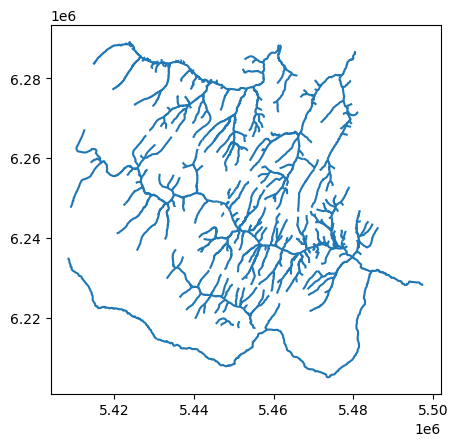

In [75]:
cursos_agua_gdf.plot()

In [77]:
cursos_agua_gdf.head()

id                 nombre                   tipo entubado  \
0   cursos_de_agua.15  Lago Parque Municipal  canal acequia o zanja       no   
1  cursos_de_agua.434              Pergamino                 arroyo       no   
2   cursos_de_agua.16              Pergamino                 arroyo       no   
3  cursos_de_agua.436              Pergamino                 arroyo       no   
4  cursos_de_agua.437              Pergamino                 arroyo       no   

  navegable     regimen  ancho_nominal etiqueta  ancho profundidad normativa  \
0        no  permanente             15     None    NaN        None      None   
1        no  permanente             30     None   14.0        None      None   
2        no  permanente             30     None    NaN        None      None   
3        no  permanente             30     None   18.0        None      None   
4        no  permanente             30     None   23.0        None      None   

  nombre_alternativo                                           geometry  
0               None  MULTILINESTRING ((5447052.834 6248801.101, 544...  
1               None  MULTILINESTRING ((5445240.6 6249088.336, 54452...  
2               None  MULTILINESTRING ((5428562.014 6251122.244, 542...  
3               None  MULTILINESTRING ((5445872.323 6249121.482, 544...  
4               None  MULTILINESTRING ((5446501.26 6248957.71, 54464...

Distance range: 0 - 12757 meters


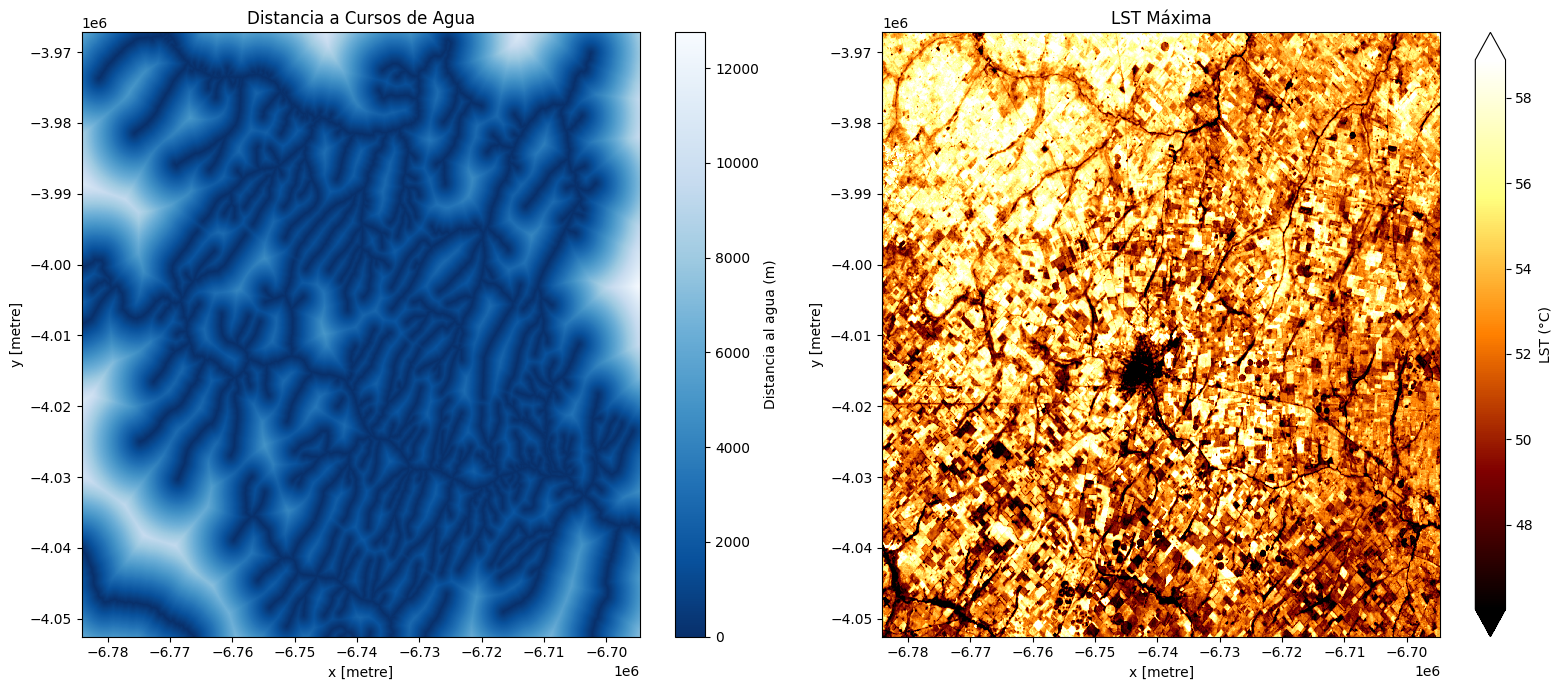

In [79]:
from rasterio import features
import numpy as np

# 1. Align watercourses to LST grid
cursos_agua_aligned = cursos_agua_gdf.to_crs(LST_max_computed.rio.crs)

# 2. Get transform and shape from LST raster
transform = LST_max_computed.rio.transform()
shape = LST_max_computed.shape

# 3. Rasterize water features directly
water_mask = features.rasterize(
    shapes=cursos_agua_aligned.geometry,
    out_shape=shape,
    transform=transform,
    fill=0,
    default_value=1,
    dtype="uint8",
)

# 4. Calculate distance transform
from scipy.ndimage import distance_transform_edt

distance_pixels = distance_transform_edt(~water_mask.astype(bool))

# Convert to meters
pixel_size = abs(float(LST_max_computed.rio.resolution()[0]))
distance_meters = distance_pixels * pixel_size

# 5. Create xarray with proper coords
distance_to_water = LST_max_computed.copy()
distance_to_water.values = distance_meters
distance_to_water.name = "distance_to_water"

print(
    f"Distance range: {distance_to_water.min().values:.0f} - {distance_to_water.max().values:.0f} meters"
)

# 6. Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

distance_to_water.plot(
    ax=ax1, cmap="Blues_r", cbar_kwargs={"label": "Distancia al agua (m)"}
)
ax1.set_title("Distancia a Cursos de Agua")

LST_max_computed.plot(
    ax=ax2, cmap="afmhot", robust=True, cbar_kwargs={"label": "LST (°C)"}
)
ax2.set_title("LST Máxima")

plt.tight_layout()
plt.show()

Píxeles urbanos válidos: 32,779


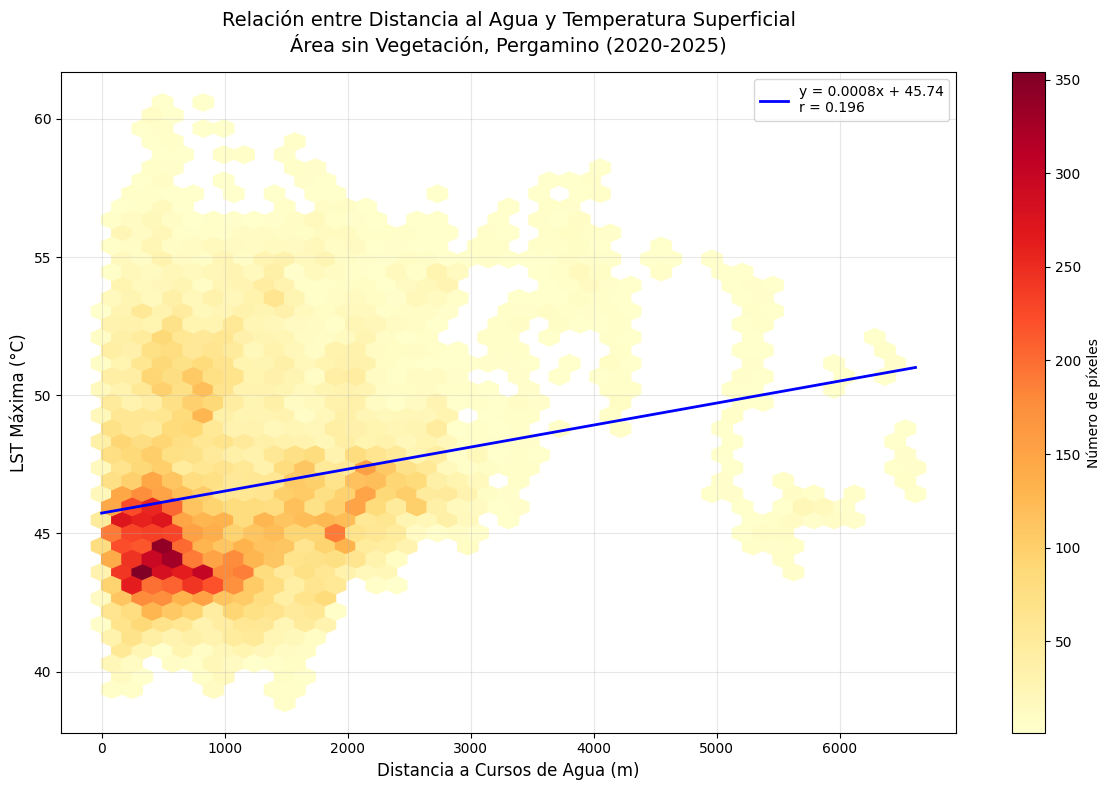


Correlación: 0.196
Distancia al agua:
  Percentiles: 25%=457m, 50%=888m, 75%=1613m, 95%=2598m


In [82]:
# 1. Align all rasters to same grid
distance_aligned = distance_to_water.values.flatten()
lst_flat = LST_max_computed.values.flatten()
landcover_flat = suelo_aligned.values.flatten()

# 2. Filter for urban pixels (ID 22) with valid data
urban_mask = (
    (landcover_flat == 22) & (~np.isnan(lst_flat)) & (~np.isnan(distance_aligned))
)

lst_urban = lst_flat[urban_mask]
distance_urban = distance_aligned[urban_mask]

print(f"Píxeles urbanos válidos: {len(lst_urban):,}")

# 3. Scatterplot
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.hexbin(distance_urban, lst_urban, gridsize=40, cmap="YlOrRd", mincnt=1)
plt.colorbar(scatter, ax=ax, label="Número de píxeles")

# 4. Add linear regression line
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(
    distance_urban, lst_urban
)

x_line = np.linspace(distance_urban.min(), distance_urban.max(), 100)
y_line = slope * x_line + intercept
ax.plot(
    x_line,
    y_line,
    "b-",
    linewidth=2,
    label=f"y = {slope:.4f}x + {intercept:.2f}\nr = {r_value:.3f}",
)
ax.legend()

ax.set_xlabel("Distancia a Cursos de Agua (m)", fontsize=12)
ax.set_ylabel("LST Máxima (°C)", fontsize=12)
ax.set_title(
    "Relación entre Distancia al Agua y Temperatura Superficial\nÁrea sin Vegetación, Pergamino (2020-2025)",
    fontsize=14,
    pad=15,
)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Stats
correlation = np.corrcoef(distance_urban, lst_urban)[0, 1]
print(f"\nCorrelación: {correlation:.3f}")
print("Distancia al agua:")
print(
    f"  Percentiles: 25%={np.percentile(distance_urban, 25):.0f}m, 50%={np.percentile(distance_urban, 50):.0f}m, 75%={np.percentile(distance_urban, 75):.0f}m, 95%={np.percentile(distance_urban, 95):.0f}m"
)

## Arbolado

In [92]:
import requests
import geopandas as gpd

arbolado_layer_name = "publico:cobertura_arbolado_urbano"

params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typename": arbolado_layer_name,
    "outputFormat": "application/json",
    "srsname": "EPSG:4326",
    "bbox": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]},EPSG:4326",
}

response = requests.get(wfs_url, params=params)

if response.status_code == 200:
    arbolado_gdf = gpd.read_file(BytesIO(response.content))
    print(f"Loaded {len(arbolado_gdf)} tree features")

    arbolado_gdf = arbolado_gdf.to_crs(pergamino.crs)

else:
    print(f"Error: {response.status_code}")
    print(response.text)

Loaded 45825 tree features


In [93]:
arbolado_gdf.columns

Index(['id', 'localidad', 'barrio', 'area', 'perimetro', 'espacio_verde',
       'metodo_deteccion', 'geometry'],
      dtype='object')

In [94]:
arbolado_gdf.head()

id                    localidad  \
0  cobertura_arbolado_urbano.1303  El Socorro (Villa Angélica)   
1  cobertura_arbolado_urbano.1304  El Socorro (Villa Angélica)   
2  cobertura_arbolado_urbano.1305  El Socorro (Villa Angélica)   
3  cobertura_arbolado_urbano.1306  El Socorro (Villa Angélica)   
4  cobertura_arbolado_urbano.1307  El Socorro (Villa Angélica)   

                        barrio        area   perimetro espacio_verde  \
0  El Socorro (Villa Angélica)  227.399265   71.789361            no   
1  El Socorro (Villa Angélica)   27.347031   20.020147            no   
2  El Socorro (Villa Angélica)   28.825322   21.948760            no   
3                        Rural  674.192882  147.222432            no   
4  El Socorro (Villa Angélica)    6.159263   10.012463            no   

  metodo_deteccion                                           geometry  
0       automatica  MULTIPOLYGON (((5434280.41 6274981.206, 543428...  
1       automatica  MULTIPOLYGON (((5434149.118 6274972.381, 54341...  
2       automatica  MULTIPOLYGON (((5434219.238 6274977.32, 543422...  
3       automatica  MULTIPOLYGON (((5434001.308 6274977.803, 54339...  
4       automatica  MULTIPOLYGON (((5434251.063 6274980.014, 54342...

<Axes: >

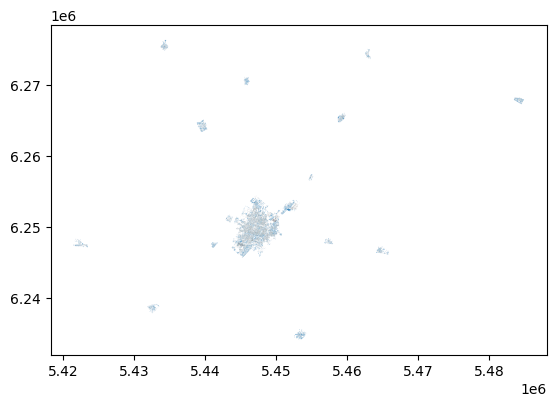

In [95]:
arbolado_gdf.plot()

In [96]:
from rasterio import features
import numpy as np

# 1. Align canopy to LST grid
cobertura_aligned = arbolado_gdf.to_crs(LST_max_computed.rio.crs)

# 2. Get grid info from LST
transform = LST_max_computed.rio.transform()
shape = LST_max_computed.shape
pixel_size = abs(float(LST_max_computed.rio.resolution()[0]))
pixel_area = pixel_size**2  # 30m × 30m = 900 m²

print(f"Grid: {shape}, Pixel size: {pixel_size}m, Pixel area: {pixel_area} m²")

Grid: (2845, 2985), Pixel size: 30.0m, Pixel area: 900.0 m²


In [100]:
# 3. Create empty array for canopy coverage
canopy_coverage = np.zeros(shape, dtype=np.float32)

# 4. Rasterize: sum of intersecting canopy areas per pixel
print("Rasterizing tree canopy...")

# Use a finer internal resolution to better capture partial coverage
# Rasterize at higher resolution, then aggregate
upscale = 10  # 10x finer = 3m resolution internally
fine_shape = (shape[0] * upscale, shape[1] * upscale)
fine_transform = transform * transform.scale(1 / upscale, 1 / upscale)

# Rasterize canopy as binary mask at fine resolution
fine_mask = features.rasterize(
    shapes=cobertura_aligned.geometry,
    out_shape=fine_shape,
    transform=fine_transform,
    fill=0,
    default_value=1,
    dtype="uint8",
)

# 5. Aggregate to target resolution (percentage coverage)
# Reshape and calculate mean (= % coverage at finer resolution)
canopy_percent = (
    fine_mask.reshape(shape[0], upscale, shape[1], upscale).mean(axis=(1, 3)) * 100
)  # Convert to percentage

# 6. Create xarray aligned with LST
canopy_coverage_xr = LST_max_computed.copy()
canopy_coverage_xr.values = canopy_percent
canopy_coverage_xr.name = "canopy_coverage_percent"

print(
    f"Canopy coverage range: {canopy_coverage_xr.min().values:.2f}% - {canopy_coverage_xr.max().values:.2f}%"
)
print(f"Mean coverage: {canopy_coverage_xr.mean().values:.2f}%")

Rasterizing tree canopy...
Canopy coverage range: 0.00% - 100.00%
Mean coverage: 0.15%


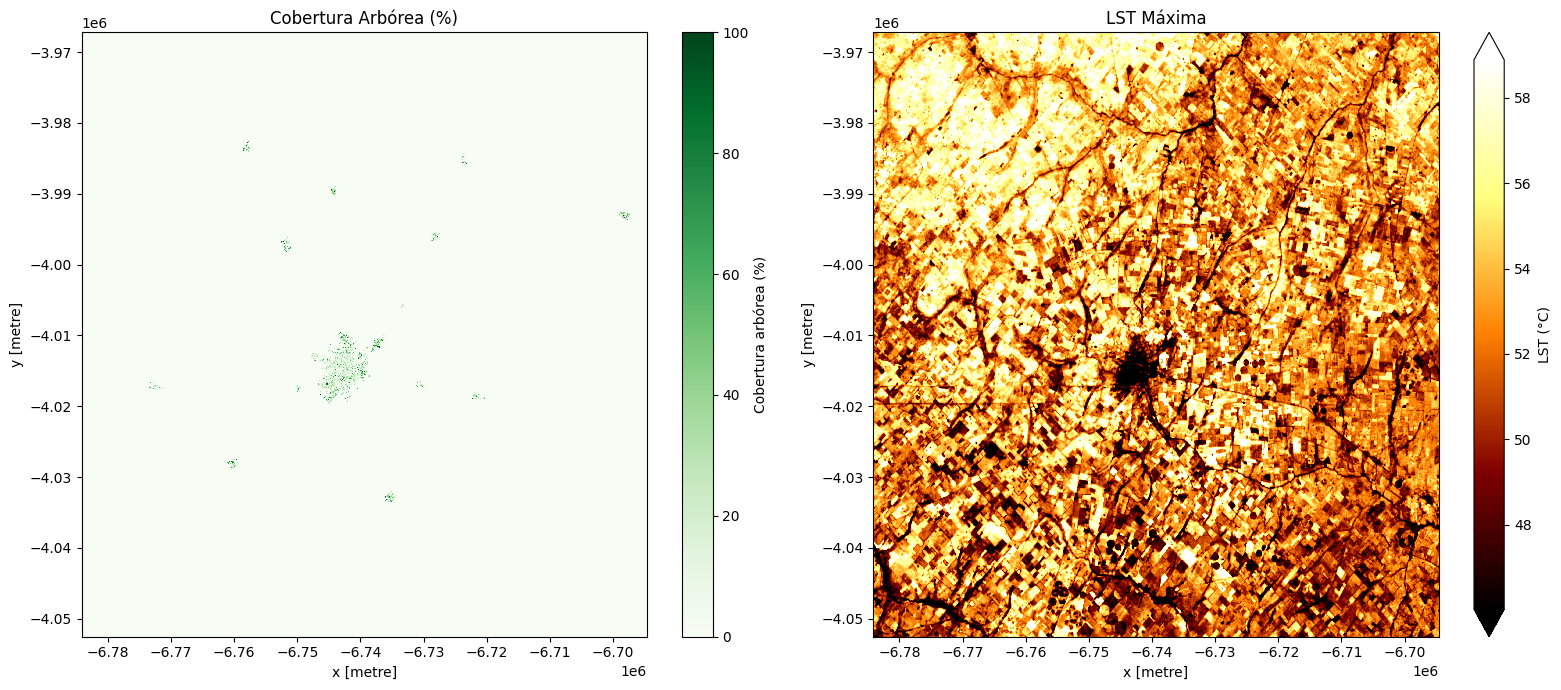

In [101]:
# 7. Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

canopy_coverage_xr.plot(
    ax=ax1,
    cmap="Greens",
    vmin=0,
    vmax=100,
    cbar_kwargs={"label": "Cobertura arbórea (%)"},
)
ax1.set_title("Cobertura Arbórea (%)")

LST_max_computed.plot(
    ax=ax2, cmap="afmhot", robust=True, cbar_kwargs={"label": "LST (°C)"}
)
ax2.set_title("LST Máxima")

plt.tight_layout()
plt.show()

Píxeles urbanos válidos: 32,779


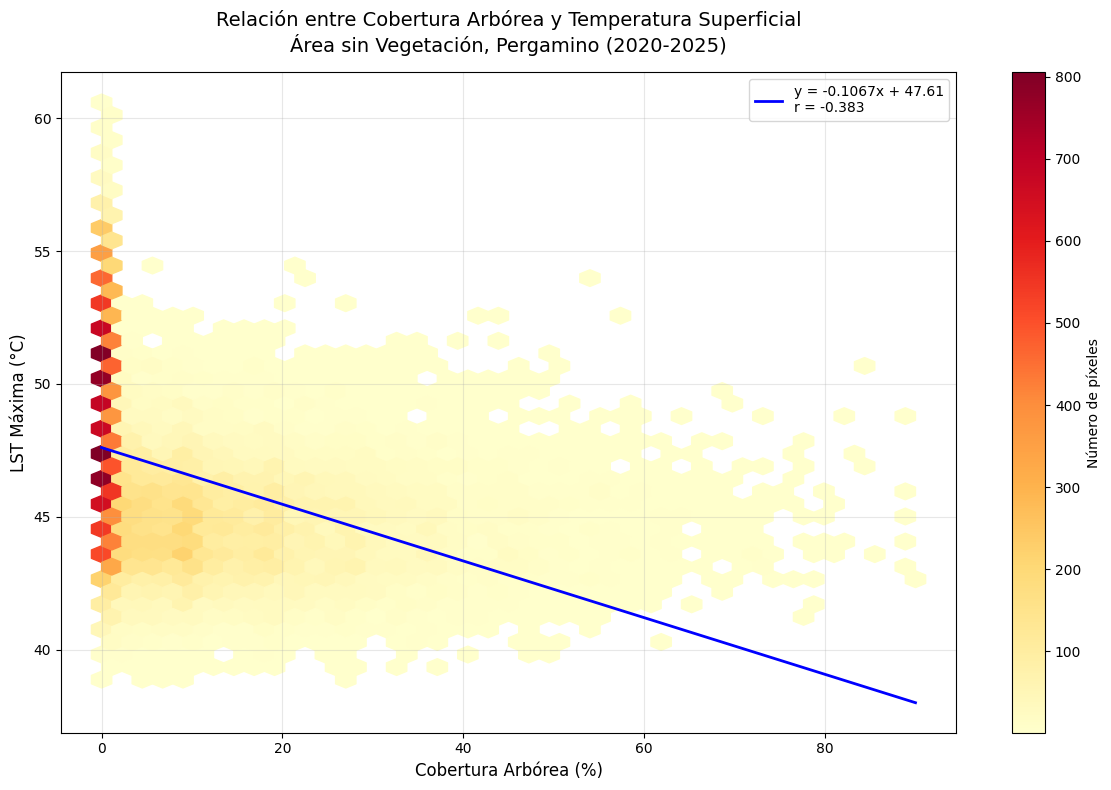


Correlación: -0.383
Cobertura arbórea:
  Percentiles: 25%=0.0%, 50%=4.0%, 75%=14.0%, 95%=35.0%


In [102]:
# 1. Flatten all rasters
canopy_flat = canopy_coverage_xr.values.flatten()
lst_flat = LST_max_computed.values.flatten()
landcover_flat = suelo_aligned.values.flatten()

# 2. Filter for urban pixels (ID 22) with valid data
urban_mask = (landcover_flat == 22) & (~np.isnan(lst_flat)) & (~np.isnan(canopy_flat))

lst_urban = lst_flat[urban_mask]
canopy_urban = canopy_flat[urban_mask]

print(f"Píxeles urbanos válidos: {len(lst_urban):,}")

# 3. Scatterplot
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.hexbin(canopy_urban, lst_urban, gridsize=40, cmap="YlOrRd", mincnt=1)
plt.colorbar(scatter, ax=ax, label="Número de píxeles")

# 4. Add linear regression line
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(canopy_urban, lst_urban)

x_line = np.linspace(canopy_urban.min(), canopy_urban.max(), 100)
y_line = slope * x_line + intercept
ax.plot(
    x_line,
    y_line,
    "b-",
    linewidth=2,
    label=f"y = {slope:.4f}x + {intercept:.2f}\nr = {r_value:.3f}",
)
ax.legend()

ax.set_xlabel("Cobertura Arbórea (%)", fontsize=12)
ax.set_ylabel("LST Máxima (°C)", fontsize=12)
ax.set_title(
    "Relación entre Cobertura Arbórea y Temperatura Superficial\nÁrea sin Vegetación, Pergamino (2020-2025)",
    fontsize=14,
    pad=15,
)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Stats
correlation = np.corrcoef(canopy_urban, lst_urban)[0, 1]
print(f"\nCorrelación: {correlation:.3f}")
print("Cobertura arbórea:")
print(
    f"  Percentiles: 25%={np.percentile(canopy_urban, 25):.1f}%, 50%={np.percentile(canopy_urban, 50):.1f}%, 75%={np.percentile(canopy_urban, 75):.1f}%, 95%={np.percentile(canopy_urban, 95):.1f}%"
)

## Modelación

Urban pixels for modeling: 32,779

INDIVIDUAL MODELS

Canopy Coverage:
  R² = 0.1465 (14.65% variance explained)
  Coefficient = -0.1067, p-value = 0.00e+00

Building Density (log):
  R² = 0.0366 (3.66% variance explained)
  Coefficient = -0.7507, p-value = 6.87e-268

Distance to Water:
  R² = 0.0385 (3.85% variance explained)
  Coefficient = 0.0008, p-value = 6.59e-282

MULTIPLE LINEAR REGRESSION

R² = 0.2191 (21.91% variance explained)
Adjusted R² = 0.2190

Coefficients:
  Intercept                     : +45.6251
  Canopy Coverage (%)           : -0.1060
  Building Density (log10)      : -0.7984
  Distance to Water (m)         : +0.0007


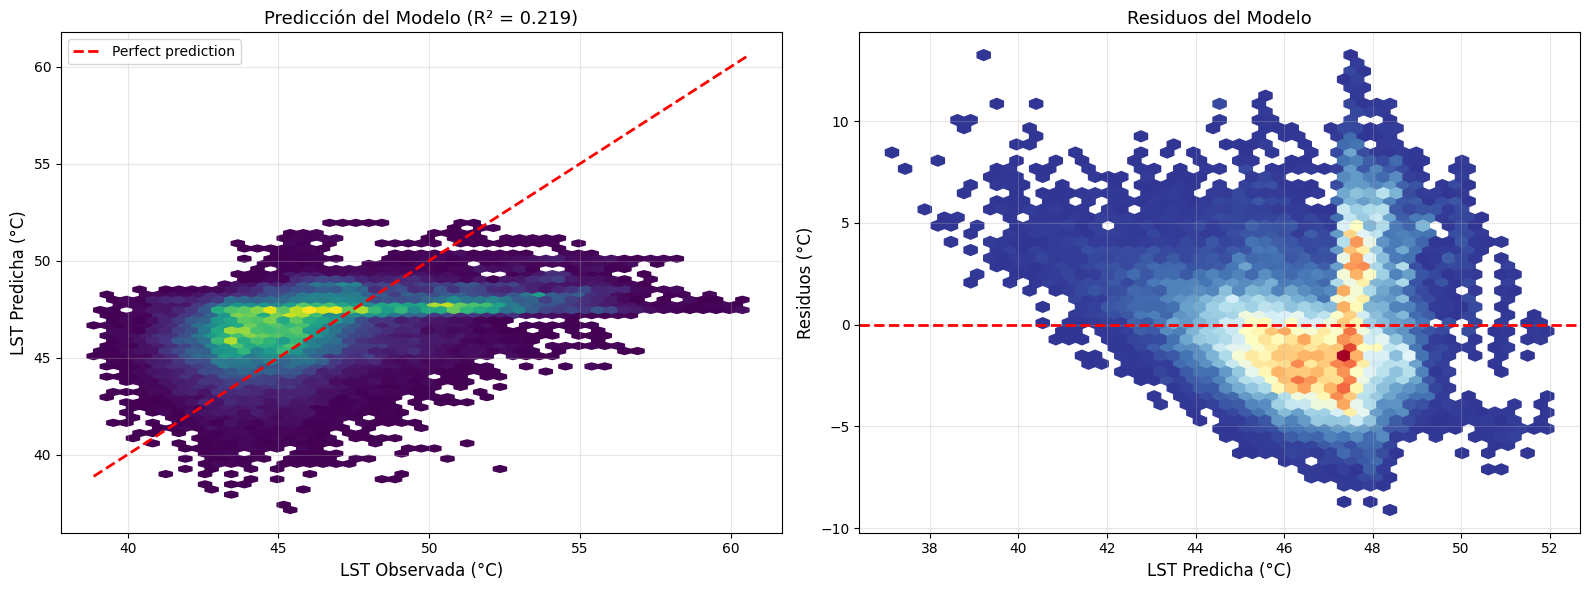


Combined model explains 21.9% of LST variance in urban areas


In [106]:
import pandas as pd
from scipy import stats
import numpy as np

# 1. Prepare data (same as before)
canopy_flat = canopy_coverage_xr.values.flatten()
density_flat = volume_density_aligned.values.flatten()
distance_flat = distance_to_water.values.flatten()
lst_flat = LST_max_computed.values.flatten()
landcover_flat = suelo_aligned.values.flatten()

urban_mask = (
    (landcover_flat == 22)
    & (~np.isnan(lst_flat))
    & (~np.isnan(canopy_flat))
    & (~np.isnan(density_flat))
    & (~np.isnan(distance_flat))
)

df_urban = pd.DataFrame(
    {
        "LST": lst_flat[urban_mask],
        "Canopy_Coverage": canopy_flat[urban_mask],
        "Building_Density": density_flat[urban_mask],
        "Distance_Water": distance_flat[urban_mask],
    }
)

print(f"Urban pixels for modeling: {len(df_urban):,}\n")

# 2. Individual models
print("=" * 70)
print("INDIVIDUAL MODELS")
print("=" * 70)

predictors = [
    ("Canopy Coverage", df_urban["Canopy_Coverage"]),
    ("Building Density (log)", np.log10(df_urban["Building_Density"] + 0.01)),
    ("Distance to Water", df_urban["Distance_Water"]),
]

for name, X in predictors:
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, df_urban["LST"])
    r2 = r_value**2
    print(f"\n{name}:")
    print(f"  R² = {r2:.4f} ({r2 * 100:.2f}% variance explained)")
    print(f"  Coefficient = {slope:.4f}, p-value = {p_value:.2e}")

# 3. Multiple Linear Regression using numpy
print("\n" + "=" * 70)
print("MULTIPLE LINEAR REGRESSION")
print("=" * 70)

# Design matrix (add intercept column)
X = np.column_stack(
    [
        np.ones(len(df_urban)),  # Intercept
        df_urban["Canopy_Coverage"],
        np.log10(df_urban["Building_Density"] + 0.01),
        df_urban["Distance_Water"],
    ]
)
y = df_urban["LST"].values

# Ordinary Least Squares: β = (X'X)^(-1) X'y
beta = np.linalg.lstsq(X, y, rcond=None)[0]

# Predictions
y_pred = X @ beta

# R²
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
r2_multi = 1 - (ss_res / ss_tot)
adj_r2 = 1 - (1 - r2_multi) * (len(y) - 1) / (len(y) - X.shape[1])

print(f"\nR² = {r2_multi:.4f} ({r2_multi * 100:.2f}% variance explained)")
print(f"Adjusted R² = {adj_r2:.4f}")

print("\nCoefficients:")
feature_names = [
    "Intercept",
    "Canopy Coverage (%)",
    "Building Density (log10)",
    "Distance to Water (m)",
]
for name, coef in zip(feature_names, beta):
    print(f"  {name:30s}: {coef:+.4f}")

# 4. Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Predicted vs Actual
axes[0].hexbin(y, y_pred, gridsize=50, cmap="viridis", mincnt=1)
axes[0].plot(
    [y.min(), y.max()], [y.min(), y.max()], "r--", lw=2, label="Perfect prediction"
)
axes[0].set_xlabel("LST Observada (°C)", fontsize=12)
axes[0].set_ylabel("LST Predicha (°C)", fontsize=12)
axes[0].set_title(f"Predicción del Modelo (R² = {r2_multi:.3f})", fontsize=13)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuals
residuals = y - y_pred
axes[1].hexbin(y_pred, residuals, gridsize=50, cmap="RdYlBu_r", mincnt=1)
axes[1].axhline(0, color="red", linestyle="--", linewidth=2)
axes[1].set_xlabel("LST Predicha (°C)", fontsize=12)
axes[1].set_ylabel("Residuos (°C)", fontsize=12)
axes[1].set_title("Residuos del Modelo", fontsize=13)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCombined model explains {r2_multi * 100:.1f}% of LST variance in urban areas")

In [115]:
from scipy import stats as sp_stats

# Rerun optimal model with significance tests
sigma = 7.0
print(f"Final Model (sigma={sigma}, ~420m radius)\n")

# Smooth predictors
canopy_smoothed = gaussian_filter(canopy_coverage_xr.values, sigma=sigma)
density_smoothed = gaussian_filter(
    np.log10(volume_density_aligned.values + 0.01), sigma=sigma
)
distance_smoothed = gaussian_filter(distance_to_water.values, sigma=sigma)

df_urban["Canopy_Lag"] = canopy_smoothed.flatten()[urban_mask]
df_urban["Density_Lag"] = density_smoothed.flatten()[urban_mask]
df_urban["Distance_Lag"] = distance_smoothed.flatten()[urban_mask]

# Build model
X_spatial = np.column_stack(
    [
        np.ones(len(df_urban)),
        df_urban["Canopy_Coverage"],
        np.log10(df_urban["Building_Density"] + 0.01),
        df_urban["Distance_Water"],
        df_urban["Canopy_Lag"],
        df_urban["Density_Lag"],
        df_urban["Distance_Lag"],
    ]
)
y = df_urban["LST"].values

# Fit model
beta = np.linalg.lstsq(X_spatial, y, rcond=None)[0]
y_pred = X_spatial @ beta

# Calculate standard errors and p-values
n = len(y)
k = X_spatial.shape[1] - 1  # Number of predictors (excluding intercept)
residuals = y - y_pred
mse = np.sum(residuals**2) / (n - k - 1)

# Variance-covariance matrix
var_covar = mse * np.linalg.inv(X_spatial.T @ X_spatial)
std_errors = np.sqrt(np.diag(var_covar))

# t-statistics and p-values
t_stats = beta / std_errors
p_values = 2 * (1 - sp_stats.t.cdf(np.abs(t_stats), df=n - k - 1))

# 95% confidence intervals
ci_95 = 1.96 * std_errors

# Print results
feature_names = [
    "Intercept",
    "Canopy (%)",
    "Building (log)",
    "Distance (m)",
    "Neighbor Canopy (%)",
    "Neighbor Building (log)",
    "Neighbor Distance (m)",
]

print("=" * 80)
print(
    f"{'Variable':<28s} | {'Coef':>8s} | {'Std Err':>8s} | {'t-stat':>8s} | {'p-value':>10s} | {'Sig':>4s}"
)
print("=" * 80)

for i, (name, coef, se, t, p) in enumerate(
    zip(feature_names, beta, std_errors, t_stats, p_values)
):
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
    print(f"{name:<28s} | {coef:+8.4f} | {se:8.4f} | {t:+8.2f} | {p:10.2e} | {sig:>4s}")

print("=" * 80)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05\n")

# Practical interpretations
print("=" * 80)
print("PRACTICAL EFFECTS (holding other variables constant)")
print("=" * 80)

print("\nLocal Effects (your pixel):")
print(f"  +10% canopy          → {beta[1] * 10:+.2f}°C")
print(f"  10× building density → {beta[2]:+.2f}°C (log scale)")
print(f"  +1000m from water    → {beta[3] * 1000:+.2f}°C")

print("\nNeighborhood Effects (within 420m):")
print(f"  +10% canopy          → {beta[4] * 10:+.2f}°C  ← STRONGEST COOLING")
print(f"  10× building density → {beta[5]:+.2f}°C  ← HUGE COOLING (shadows!)")
print(f"  +1000m from water    → {beta[6] * 1000:+.2f}°C")

print("\nComposite Scenario - Adding Trees to Neighborhood:")
print("  Increase neighborhood canopy from 10% → 30%")
print(f"  Effect: {beta[4] * 20:+.2f}°C cooling")
print("  (= planting street trees across 4-5 blocks)")

# R² info
r2 = 1 - (np.sum(residuals**2) / np.sum((y - y.mean()) ** 2))
print("\nModel Performance:")
print(f"  R² = {r2:.4f} ({r2 * 100:.1f}% variance explained)")
print(f"  RMSE = {np.sqrt(mse):.2f}°C")

Final Model (sigma=7.0, ~420m radius)

Variable                     |     Coef |  Std Err |   t-stat |    p-value |  Sig
Intercept                    | +36.1854 |   0.1042 |  +347.13 |   0.00e+00 |  ***
Canopy (%)                   |  -0.0126 |   0.0009 |   -14.55 |   0.00e+00 |  ***
Building (log)               |  -0.0367 |   0.0114 |    -3.23 |   1.25e-03 |   **
Distance (m)                 |  +0.0058 |   0.0002 |   +23.56 |   0.00e+00 |  ***
Neighbor Canopy (%)          |  -0.2122 |   0.0021 |  -100.44 |   0.00e+00 |  ***
Neighbor Building (log)      |  -7.6512 |   0.0557 |  -137.43 |   0.00e+00 |  ***
Neighbor Distance (m)        |  -0.0055 |   0.0003 |   -21.87 |   0.00e+00 |  ***
Significance: *** p<0.001, ** p<0.01, * p<0.05

PRACTICAL EFFECTS (holding other variables constant)

Local Effects (your pixel):
  +10% canopy          → -0.13°C
  10× building density → -0.04°C (log scale)
  +1000m from water    → +5.82°C

Neighborhood Effects (within 420m):
  +10% canopy          → -2

Testing different sigma values...

 Sigma | Radius (m) |     R² |  Adj R²
---------------------------------------------
   0.5 |         30 | 0.4402 |  0.4401
   1.0 |         60 | 0.5371 |  0.5370
   1.5 |         90 | 0.6144 |  0.6143
   2.0 |        120 | 0.6630 |  0.6629
   3.0 |        180 | 0.7129 |  0.7128
   4.0 |        240 | 0.7330 |  0.7330
   5.0 |        300 | 0.7414 |  0.7413
   6.0 |        360 | 0.7447 |  0.7447
   7.0 |        420 | 0.7457 |  0.7457
   8.0 |        480 | 0.7455 |  0.7455
   9.0 |        540 | 0.7447 |  0.7446
  10.0 |        600 | 0.7435 |  0.7434

OPTIMAL: sigma = 7.0 (≈420m radius)
R² = 0.7457 (74.57%)
Adjusted R² = 0.7457


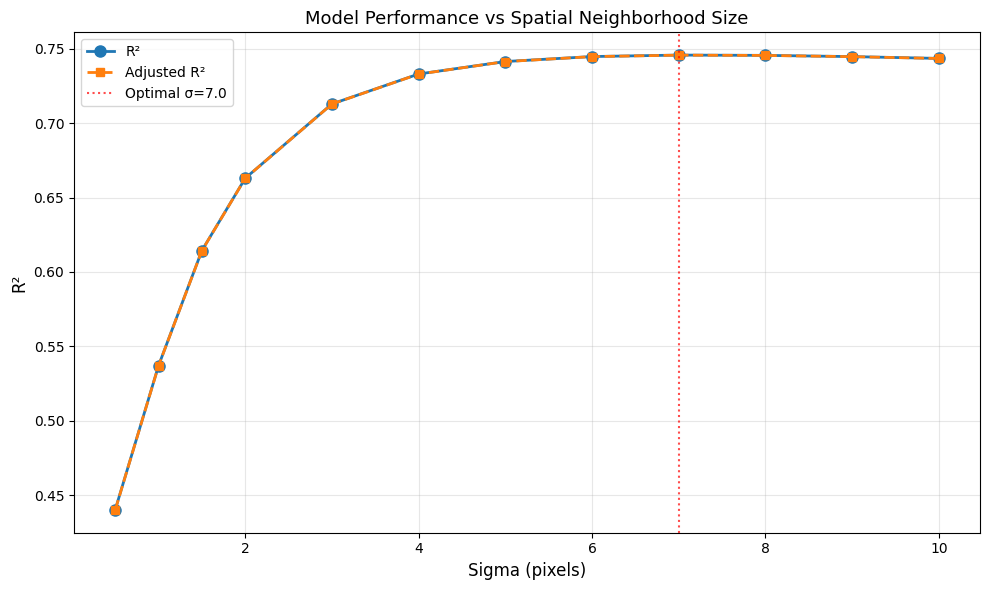

In [113]:
from scipy.ndimage import gaussian_filter

# Test range of sigma values
sigma_values = [0.5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]
results = []

print("Testing different sigma values...\n")
print(f"{'Sigma':>6s} | {'Radius (m)':>10s} | {'R²':>6s} | {'Adj R²':>7s}")
print("-" * 45)

for sigma in sigma_values:
    # Smooth each predictor
    canopy_smoothed = gaussian_filter(canopy_coverage_xr.values, sigma=sigma)
    density_smoothed = gaussian_filter(
        np.log10(volume_density_aligned.values + 0.01), sigma=sigma
    )
    distance_smoothed = gaussian_filter(distance_to_water.values, sigma=sigma)

    # Extract for urban pixels
    canopy_lag = canopy_smoothed.flatten()[urban_mask]
    density_lag = density_smoothed.flatten()[urban_mask]
    distance_lag = distance_smoothed.flatten()[urban_mask]

    # Build model
    X_spatial = np.column_stack(
        [
            np.ones(len(df_urban)),
            df_urban["Canopy_Coverage"],
            np.log10(df_urban["Building_Density"] + 0.01),
            df_urban["Distance_Water"],
            canopy_lag,
            density_lag,
            distance_lag,
        ]
    )
    y = df_urban["LST"].values

    beta = np.linalg.lstsq(X_spatial, y, rcond=None)[0]
    y_pred = X_spatial @ beta

    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    adj_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - X_spatial.shape[1])

    radius_m = sigma * 2 * 30  # Approximate 2-sigma radius in meters (95% of weight)
    results.append({"sigma": sigma, "radius_m": radius_m, "r2": r2, "adj_r2": adj_r2})

    print(f"{sigma:6.1f} | {radius_m:10.0f} | {r2:6.4f} | {adj_r2:7.4f}")

# Find optimal
results_df = pd.DataFrame(results)
best = results_df.loc[results_df["r2"].idxmax()]

print("\n" + "=" * 45)
print(f"OPTIMAL: sigma = {best['sigma']:.1f} (≈{best['radius_m']:.0f}m radius)")
print(f"R² = {best['r2']:.4f} ({best['r2'] * 100:.2f}%)")
print(f"Adjusted R² = {best['adj_r2']:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    results_df["sigma"], results_df["r2"], "o-", linewidth=2, markersize=8, label="R²"
)
ax.plot(
    results_df["sigma"],
    results_df["adj_r2"],
    "s--",
    linewidth=2,
    markersize=6,
    label="Adjusted R²",
)
ax.axvline(
    best["sigma"],
    color="red",
    linestyle=":",
    alpha=0.7,
    label=f"Optimal σ={best['sigma']:.1f}",
)
ax.set_xlabel("Sigma (pixels)", fontsize=12)
ax.set_ylabel("R²", fontsize=12)
ax.set_title("Model Performance vs Spatial Neighborhood Size", fontsize=13)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()